#  0. 用matplotlib找系统中字体文件大于1MB的
> 中文字体通常很大，这样过滤出的 通常有中文字体

> 结果中 看名字  'AR PL UMing CN' 果然是中文字体

In [1]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    if 'CN' in font:
        print(font)

AR PL UMing CN
AR PL UKai CN


In [2]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#  1. 产生tick日志

#####  编译最小main加函数1语法错误 : 文件 mini_main_f1_err.c
```cpp
//文件  mini_main_f1_err.c
char* calc_name(float age, bool high, char* nick){
  if(high && age>5){
    return "child";
  }
  char name[32]={"bigPeople"};
  return name;
}
int main(int argc, char** argv){
	calc_name(10,false,"nick");
    return 0;
}


```

```bash
tick_save=true  /pubx/build-llvm15/bin/clang-15 -c  mini_main_printf.c

#corrupted double-linked list
#pure virtual method called
#terminate called without an active exception
#已放弃 (核心已转储)

#生成tick日志文件:
#-rw-rw-r--  511M  8月 12 08:24 clang-15_13324_1691799886944_1


#有输出目标文件
ls -lh  mini_main_printf.o 
#-rw-rw-r-- 1.4K  8月 12 08:29 mini_main_printf.o


#但如果 试图输出可执行文件，则崩溃的更彻底：

tick_save=true  /pubx/build-llvm15/bin/clang-15 mini_main_printf.c -o mmp

"""
pure virtual method called
terminate called without an active exception
clang-15: error: unable to execute command: Aborted (core dumped)
clang-15: error: clang frontend command failed due to signal (use -v to see invocation)
clang version 15.0.0 (git@gitcode.net:pubz/llvm-project.git 3387b19bb538e694d2d965d46c7b053d61a059e3)
Target: x86_64-unknown-linux-gnu
Thread model: posix
InstalledDir: /pubx/build-llvm15/bin
clang-15: note: diagnostic msg: 
********************

PLEASE ATTACH THE FOLLOWING FILES TO THE BUG REPORT:
Preprocessed source(s) and associated run script(s) are located at:
clang-15: note: diagnostic msg: /tmp/mini_main_printf-f6d921.c
clang-15: note: diagnostic msg: /tmp/mini_main_printf-f6d921.sh
clang-15: note: diagnostic msg: 

********************
malloc(): unsorted double linked list corrupted
malloc(): unsorted double linked list corrupted
malloc(): unsorted double linked list corrupted
malloc(): unsorted double linked list corrupted
malloc(): unsorted double linked list corrupted
...
段错误 (核心已转储)
"""
```

####  崩溃初步分析

gdb查看哪崩溃的，可以看到很奇怪，main已经完成后崩溃了，日志正常输出了，暂时不管了

```bash
gdb --args /pubx/build-llvm15/bin/clang-15 -c  mini_main_printf.c

(gdb) set environment tick_save=true

(gdb) run
Starting program: /build/pubx/build-llvm15/bin/clang-15 -c mini_main_printf.c
[Thread debugging using libthread_db enabled]

Program received signal SIGSEGV, Segmentation fault.
0x00007ffff78a17c3 in unlink_chunk (p=p@entry=0x55555cbfc0b0, av=0x7ffff7a19c80 <main_arena>) at ./malloc/malloc.c:1634
1634	./malloc/malloc.c: 没有那个文件或目录.

(gdb) bt
#0  0x00007ffff78a17c3 in unlink_chunk (p=p@entry=0x55555cbfc0b0, av=0x7ffff7a19c80 <main_arena>) at ./malloc/malloc.c:1634
#1  0x00007ffff78a2939 in _int_free (av=0x7ffff7a19c80 <main_arena>, p=0x55555cbfc0b0, have_lock=<optimized out>) at ./malloc/malloc.c:4607
#2  0x00007ffff78a54d3 in __GI___libc_free (mem=<optimized out>) at ./malloc/malloc.c:3391
#3  0x00005555570ebb47 in llvm::PassRegistry::~PassRegistry() ()
#4  0x00007ffff7845495 in __run_exit_handlers (status=0, listp=0x7ffff7a19838 <__exit_funcs>, run_list_atexit=run_list_atexit@entry=true, run_dtors=run_dtors@entry=true)
    at ./stdlib/exit.c:113
#5  0x00007ffff7845610 in __GI_exit (status=<optimized out>) at ./stdlib/exit.c:143
#6  0x00007ffff7829d97 in __libc_start_call_main (main=main@entry=0x5555561c70e0 <main>, argc=argc@entry=3, argv=argv@entry=0x7fffffffdc38) at ../sysdeps/nptl/libc_start_call_main.h:74
#7  0x00007ffff7829e40 in __libc_start_main_impl (main=0x5555561c70e0 <main>, argc=3, argv=0x7fffffffdc38, init=<optimized out>, fini=<optimized out>, rtld_fini=<optimized out>, 
    stack_end=0x7fffffffdc28) at ../csu/libc-start.c:392
#8  0x00005555561aef05 in _start ()


```

# 1. 前置

In [3]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc={'figure.figsize': (30,20)}

In [4]:
#sklearn 各种归一化
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

minMaxScaler = MinMaxScaler()
standardScaler = StandardScaler()
maxAbsScaler = MaxAbsScaler()


# df['栈净'] = minMaxScaler.fit_transform(df[['栈净']])

In [5]:
import numpy 
import math

In [6]:
import seaborn

In [7]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d




> 解决 matplotlib 中文不正常显示问题，
>
> 中文显示为方块，原因是没有中文字体，
>
> 这里 将字体设置为 上面找到的中文字体 'AR PL UMing CN'

In [8]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams['font.family'] = 'AR PL UMing CN'
matplotlib.pyplot.rcParams['font.sans-serif'] = [ 'AR PL UMing CN']

In [9]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

## 1.2 作图前置

In [10]:
#增大图例颜色圆球的尺寸
def inrease_g_size(g):
    for lh in g.legend_.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [500] 

In [11]:
import warnings
# 过滤掉RuntimeWarning警告
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 2. 加载tick日志

In [12]:
%%bash
ls -lhrt /tick_data_home/ | tail -n 1

-rw-rw-r-- 1 zz zz 445M  8月 12 16:33 clang-15_172108_1691829221822_1


In [13]:
#编译正常: mini_main.c
df=pandas.read_csv(filepath_or_buffer="/tick_data_home/clang-15_13324_1691799886944_1",sep=',' , quotechar="'")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236685 entries, 0 to 3236684
Data columns (total 22 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   滴答                 int64 
 1   funcLocalClock     int64 
 2   tickKind           int64 
 3   funcEnterId        int64 
 4   hasFuncCallChain   int64 
 5   funcEnterIdSeqLen  int64 
 6   funcEnterIdSeq     object
 7   rTSVarC            int64 
 8   d栈生                int64 
 9   d栈死                int64 
 10  d堆生                int64 
 11  d堆死                int64 
 12  栈生                 int64 
 13  栈死                 int64 
 14  栈净                 int64 
 15  堆生                 int64 
 16  堆死                 int64 
 17  堆净                 int64 
 18  srcFile            object
 19  funcLine           int64 
 20  funcCol            int64 
 21  funcName           object
dtypes: int64(19), object(3)
memory usage: 543.3+ MB


/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



# 3. funcId 构造

In [14]:
df.head(1)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory


####  3.1 新增列 funcLoc  相当于字符串样式的funId

In [15]:
#新增列 funcLoc 
df['funcLoc']=df .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
df['funcLoc'].values[:4]

array(['/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41'],
      dtype=object)

####  3.2  以 区间[0, funcLoc不重复个数-1] 作为 funcId表

In [16]:

funcLoc_values=df['funcLoc'].values
type(funcLoc_values)#numpy.ndarray
len(funcLoc_values)#1014494

funcLoc_list=list(funcLoc_values)
len(funcLoc_list)#1014494

#funcLoc转为集合
funcLoc_set=set(funcLoc_values)
len(funcLoc_set)#2838

#funcLoc集合作为列表: 即 不重复的funcLoc 列表
uqFuncLoc_Ls=list(funcLoc_set)
len(uqFuncLoc_Ls)#2838
#uq:unique

#不重复的funcLoc 列表 转为 funcId表
funcId_Tab=dict( [(fL,j) for j,fL in enumerate(uqFuncLoc_Ls)] )
list(funcId_Tab.items())[:5]

#上一版中, 此输出 源文件路径字段 左右都有粘连乱七八糟其他字符，明显是 由于使用了 已释放内存区域导致的
#这一版中，无此问题，源文件路径字段 左右很干净，说明 问题已经修复

[('/pubx/llvm-project/clang/lib/CodeGen/CGDecl.cpp_52_52', 0),
 ('/pubx/llvm-project/llvm/lib/CodeGen/LLVMTargetMachine.cpp_62_62', 1),
 ('/pubx/llvm-project/clang/lib/CodeGen/CGCall.cpp_54_54', 2),
 ('/pubx/llvm-project/llvm/lib/IR/DiagnosticInfo.cpp_58_58', 3),
 ('/pubx/llvm-project/llvm/lib/Target/X86/MCTargetDesc/X86AsmBackend.cpp_75_75',
  4)]

In [17]:

#按 funcId 查  funcLoc 表
funcId2Loc_Tab=dict( [(j,fL) for j,fL in enumerate(uqFuncLoc_Ls)] )

In [18]:
print("funcId个数:",len(funcId_Tab))

funcId个数: 2739


####  3.3  参照 funLoc列、funcId表 新增列funcId

In [19]:
#新增列 funcId 
df['funcId']=df['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
df['funcId'].values[:10]
df.head(2)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2102
1,2,2,0,0,0,0,NaN,1,1,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2102


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236685 entries, 0 to 3236684
Data columns (total 24 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   滴答                 int64 
 1   funcLocalClock     int64 
 2   tickKind           int64 
 3   funcEnterId        int64 
 4   hasFuncCallChain   int64 
 5   funcEnterIdSeqLen  int64 
 6   funcEnterIdSeq     object
 7   rTSVarC            int64 
 8   d栈生                int64 
 9   d栈死                int64 
 10  d堆生                int64 
 11  d堆死                int64 
 12  栈生                 int64 
 13  栈死                 int64 
 14  栈净                 int64 
 15  堆生                 int64 
 16  堆死                 int64 
 17  堆净                 int64 
 18  srcFile            object
 19  funcLine           int64 
 20  funcCol            int64 
 21  funcName           object
 22  funcLoc            object
 23  funcId             int64 
dtypes: int64(20), object(4)
memory usage: 592.7+ MB


#  xx

> 文件: /pubx/clang-ctk/t_clock_tick/t_clock_tick.cpp
```cpp
/**滴答种类
 *需要被正常分析的tick是 正常tick 和 函数返回tick，
 * 正常分析不需要 函数进入tick
 * 看哪里少插入了X__funcReturn: 比对 函数进入tick    和  函数返回tick 是否配对
 */
enum TickKind{
    //正常tick
    NormalTick=0,
    //函数进入tick 可作为 和 函数返回tick 做比对，看哪里少插入了X__funcReturn
    FuncEnter=1,
    //函数返回tick
    FuncReturn=2

};
```

In [21]:
NormalTick=0
#函数进入
FuncEnter=1
#函数返回tick
FuncReturn=2

In [22]:

    


df进出=df[  df['tickKind'].isin( [FuncEnter,FuncReturn] )  ]


#代码中，只有在函数进入时，计算了链条长度 并写磁盘
df链=df[  df['tickKind'].isin( [FuncEnter] )  ]

# 函数本地时长 应 用  出时的计数器的值 
df出=df[  df['tickKind'].isin( [FuncReturn] )  ]

In [23]:
df进出.shape,  df链.shape,  df出.shape

((666718, 24), (333359, 24), (333359, 24))

In [24]:
df进出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2102
2,3,1,1,1,1,2,-2100558033#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2564
4,5,1,1,2,1,3,-2100558033#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,250
6,7,1,1,3,1,4,-2100558033#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,1496
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,1496


In [25]:
df链.head(5)
#多出的复数 -1616939133  应该是循环边界问题，不影响链长使用

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2102
2,3,1,1,1,1,2,-2100558033#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2564
4,5,1,1,2,1,3,-2100558033#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,250
6,7,1,1,3,1,4,-2100558033#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,1496
9,10,1,1,4,1,4,-2100558033#4#2#1#'',0,0,0,...,2,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,2111


In [26]:
df出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,1496
11,12,3,2,4,0,0,NaN,1,0,1,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,2111
17,18,2,2,6,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,1496
21,22,3,2,7,0,0,NaN,1,0,1,...,5,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,2111
30,31,12,2,5,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,250


In [27]:
df出.funcLocalClock.describe()

count    333359.000000
mean          9.689887
std         140.861247
min           2.000000
25%           3.000000
50%           5.000000
75%          11.000000
max       62308.000000
Name: funcLocalClock, dtype: float64

In [28]:
函数本地时长分组 = df出.groupby('funcLocalClock').size().reset_index(name='该时长的出数')

函数本地时长分组_降序 = 函数本地时长分组.sort_values(by='该时长的出数', ascending=False)
函数本地时长分组_降序.head(5)

,funcLocalClock,该时长的出数
2,4,58087
1,3,57961
0,2,42770
3,5,24562
4,6,21673


In [29]:
函数本地时长分组_降序.tail(5)

,funcLocalClock,该时长的出数
209,271,1
208,268,1
207,266,1
206,264,1
310,62308,1


过滤 函数本地时长大于1 的函数们：
- 不能用 df进出 ， 因为进入的时候 本地时长才刚刚加到1 
- 只能用 df出 ，因为此时函数执行结束了，本地时长累加完毕了

####  3.4 计算 本地时长短的函数id们

In [30]:
组_函_时最 = df出.groupby('funcId')['funcLocalClock'].max()
序组_函_时最 = 组_函_时最.sort_values(ascending=False).reset_index()
序组_函_时最.columns = ['funcId', '最大funcLocalClock']
序组_函_时最

,funcId,最大funcLocalClock
0,805,62308
1,35,30363
2,79,26392
3,253,9468
4,649,9374
...,...,...
2733,1577,2
2734,726,2
2735,2163,2
2736,1574,2


In [31]:
序组_函_时最.最大funcLocalClock.unique()

array([62308, 30363, 26392,  9468,  9374,  9112,  8292,  2699,  2465,
        2255,  2006,  1413,  1350,  1284,  1131,   866,   654,   618,
         526,   493,   474,   426,   395,   392,   390,   384,   355,
         328,   326,   324,   293,   277,   238,   222,   212,   211,
         208,   206,   203,   197,   192,   180,   167,   163,   161,
         158,   157,   155,   139,   138,   131,   129,   127,   125,
         120,   119,   114,   112,   109,   108,   106,   105,   101,
         100,    96,    95,    94,    92,    90,    89,    84,    81,
          80,    79,    78,    77,    76,    75,    73,    72,    71,
          70,    69,    67,    65,    64,    63,    62,    61,    59,
          58,    57,    56,    55,    54,    53,    51,    50,    49,
          48,    47,    46,    45,    44,    43,    42,    41,    40,
          39,    38,    37,    36,    35,    34,    33,    32,    31,
          30,    29,    28,    27,    26,    25,    24,    23,    22,
          21,    20,

In [32]:
序组_时最_函个=序组_函_时最.groupby('最大funcLocalClock').size().reset_index()
序组_时最_函个.columns = ['最大funcLocalClock', 'funcId个数']
序组_时最_函个

,最大funcLocalClock,funcId个数
0,2,330
1,3,549
2,4,324
3,5,239
4,6,195
...,...,...
141,9374,1
142,9468,1
143,26392,1
144,30363,1


In [33]:
序组_时最_函个.head(20)


,最大funcLocalClock,funcId个数
0,2,330
1,3,549
2,4,324
3,5,239
4,6,195
5,7,152
6,8,106
7,9,97
8,10,63
9,11,59


In [34]:
序组_时最_函个.最大funcLocalClock.describe()

count      146.000000
mean      1273.876712
std       6229.551055
min          2.000000
25%         38.250000
50%         79.500000
75%        207.500000
max      62308.000000
Name: 最大funcLocalClock, dtype: float64

In [35]:
时长边界=200

In [36]:
本地时短funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].le(时长边界) ].funcId.values.tolist()
print(len(本地时短funId们) )

2699


In [37]:
本地时长funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].gt(时长边界) ].funcId.values.tolist()
print(len(本地时长funId们) )

39


####  3.4B  时长边界_时上链异数


In [38]:
df时=df出

时顶=序组_函_时最.最大funcLocalClock.unique().max()
时底=序组_函_时最.最大funcLocalClock.unique().min()

时长边界_时上链异数_对们=[]
for 时长边界k in range(时底,时顶):
    时上函=df时[ df时['funcLocalClock'].ge(时长边界k)  ] .funcId.unique()
    时上链=df链[ df链['funcId'].isin( 时上函 ) ]
    时上链异数=len(时上链.funcEnterIdSeq.unique())
    时长边界_时上链异数_对们.append( (时长边界k,时上链异数)  )
    if 时上链异数 <=1:
        break
    if 时长边界k % 800 == 0:
        print(f"时长边界k,时上链异数 :{时长边界k},{时上链异数}")

时长边界k,时上链异数 :800,19448
时长边界k,时上链异数 :1600,19441
时长边界k,时上链异数 :2400,18677
时长边界k,时上链异数 :3200,6633
时长边界k,时上链异数 :4000,6633
时长边界k,时上链异数 :4800,6633
时长边界k,时上链异数 :5600,6633
时长边界k,时上链异数 :6400,6633
时长边界k,时上链异数 :7200,6633
时长边界k,时上链异数 :8000,6633
时长边界k,时上链异数 :8800,6630
时长边界k,时上链异数 :9600,242
时长边界k,时上链异数 :10400,242
时长边界k,时上链异数 :11200,242
时长边界k,时上链异数 :12000,242
时长边界k,时上链异数 :12800,242
时长边界k,时上链异数 :13600,242
时长边界k,时上链异数 :14400,242
时长边界k,时上链异数 :15200,242
时长边界k,时上链异数 :16000,242
时长边界k,时上链异数 :16800,242
时长边界k,时上链异数 :17600,242
时长边界k,时上链异数 :18400,242
时长边界k,时上链异数 :19200,242
时长边界k,时上链异数 :20000,242
时长边界k,时上链异数 :20800,242
时长边界k,时上链异数 :21600,242
时长边界k,时上链异数 :22400,242
时长边界k,时上链异数 :23200,242
时长边界k,时上链异数 :24000,242
时长边界k,时上链异数 :24800,242
时长边界k,时上链异数 :25600,242
时长边界k,时上链异数 :26400,2
时长边界k,时上链异数 :27200,2
时长边界k,时上链异数 :28000,2
时长边界k,时上链异数 :28800,2
时长边界k,时上链异数 :29600,2


In [39]:
print( "时长边界_时上链异数_对们 元素个数:", len(时长边界_时上链异数_对们) )
时长边界_时上链异数_对们_转置 = numpy.array(时长边界_时上链异数_对们).T
print( "时长边界_时上链异数_对们_转置 :", 时长边界_时上链异数_对们_转置.shape,type(时长边界_时上链异数_对们_转置) )

时长边界们,时上链异数们=时长边界_时上链异数_对们_转置

时长边界_时上链异数_对们 元素个数: 30363
时长边界_时上链异数_对们_转置 : (2, 30363) <class 'numpy.ndarray'>


In [40]:
df时界上_链异数 = pandas.DataFrame({'时长边界': 时长边界们, '时上链异数': 时上链异数们})



组_链数_边界数 = df时界上_链异数.groupby('时上链异数').agg({'时长边界': ['count', 'max', 'min']})  .sort_values(('时长边界', 'count'), ascending=False)
print("组_链数_边界数.shape:",组_链数_边界数.shape)

组_链数_边界数.head(30)

组_链数_边界数.shape: (145, 3)


时长边界              
       count    max    min
时上链异数                     
242    16924  26392   9469
6633    5593   8292   2700
2       3971  30363  26393
6630     820   9112   8293
19441    593   2006   1414
19446    265   1131    867
244      262   9374   9113
19024    249   2255   2007
6634     234   2699   2466
19448    212    866    655
18677    210   2465   2256
19445    153   1284   1132
243       94   9468   9375
20815     92    618    527
19443     66   1350   1285
19442     63   1413   1351
21053     48    474    427
22630     39    277    239
19449     36    654    619
20818     33    526    494
21731     31    426    396
22626     31    324    294
22298     29    384    356
22301     27    355    329
20820     19    493    475
22633     16    238    223
22627     16    293    278
30736     16    155    140
29762     13    180    168
29741     12    192    181

In [41]:

_第一行 = 组_链数_边界数.iloc[0]
多数点_时上链异数 = _第一行.name
多数点_时长边界_底 = _第一行[('时长边界', 'min')]
print("多数点_时上链异数,多数点_时长边界_底:", 多数点_时上链异数,多数点_时长边界_底)

多数点_时上链异数,多数点_时长边界_底: 242 9469


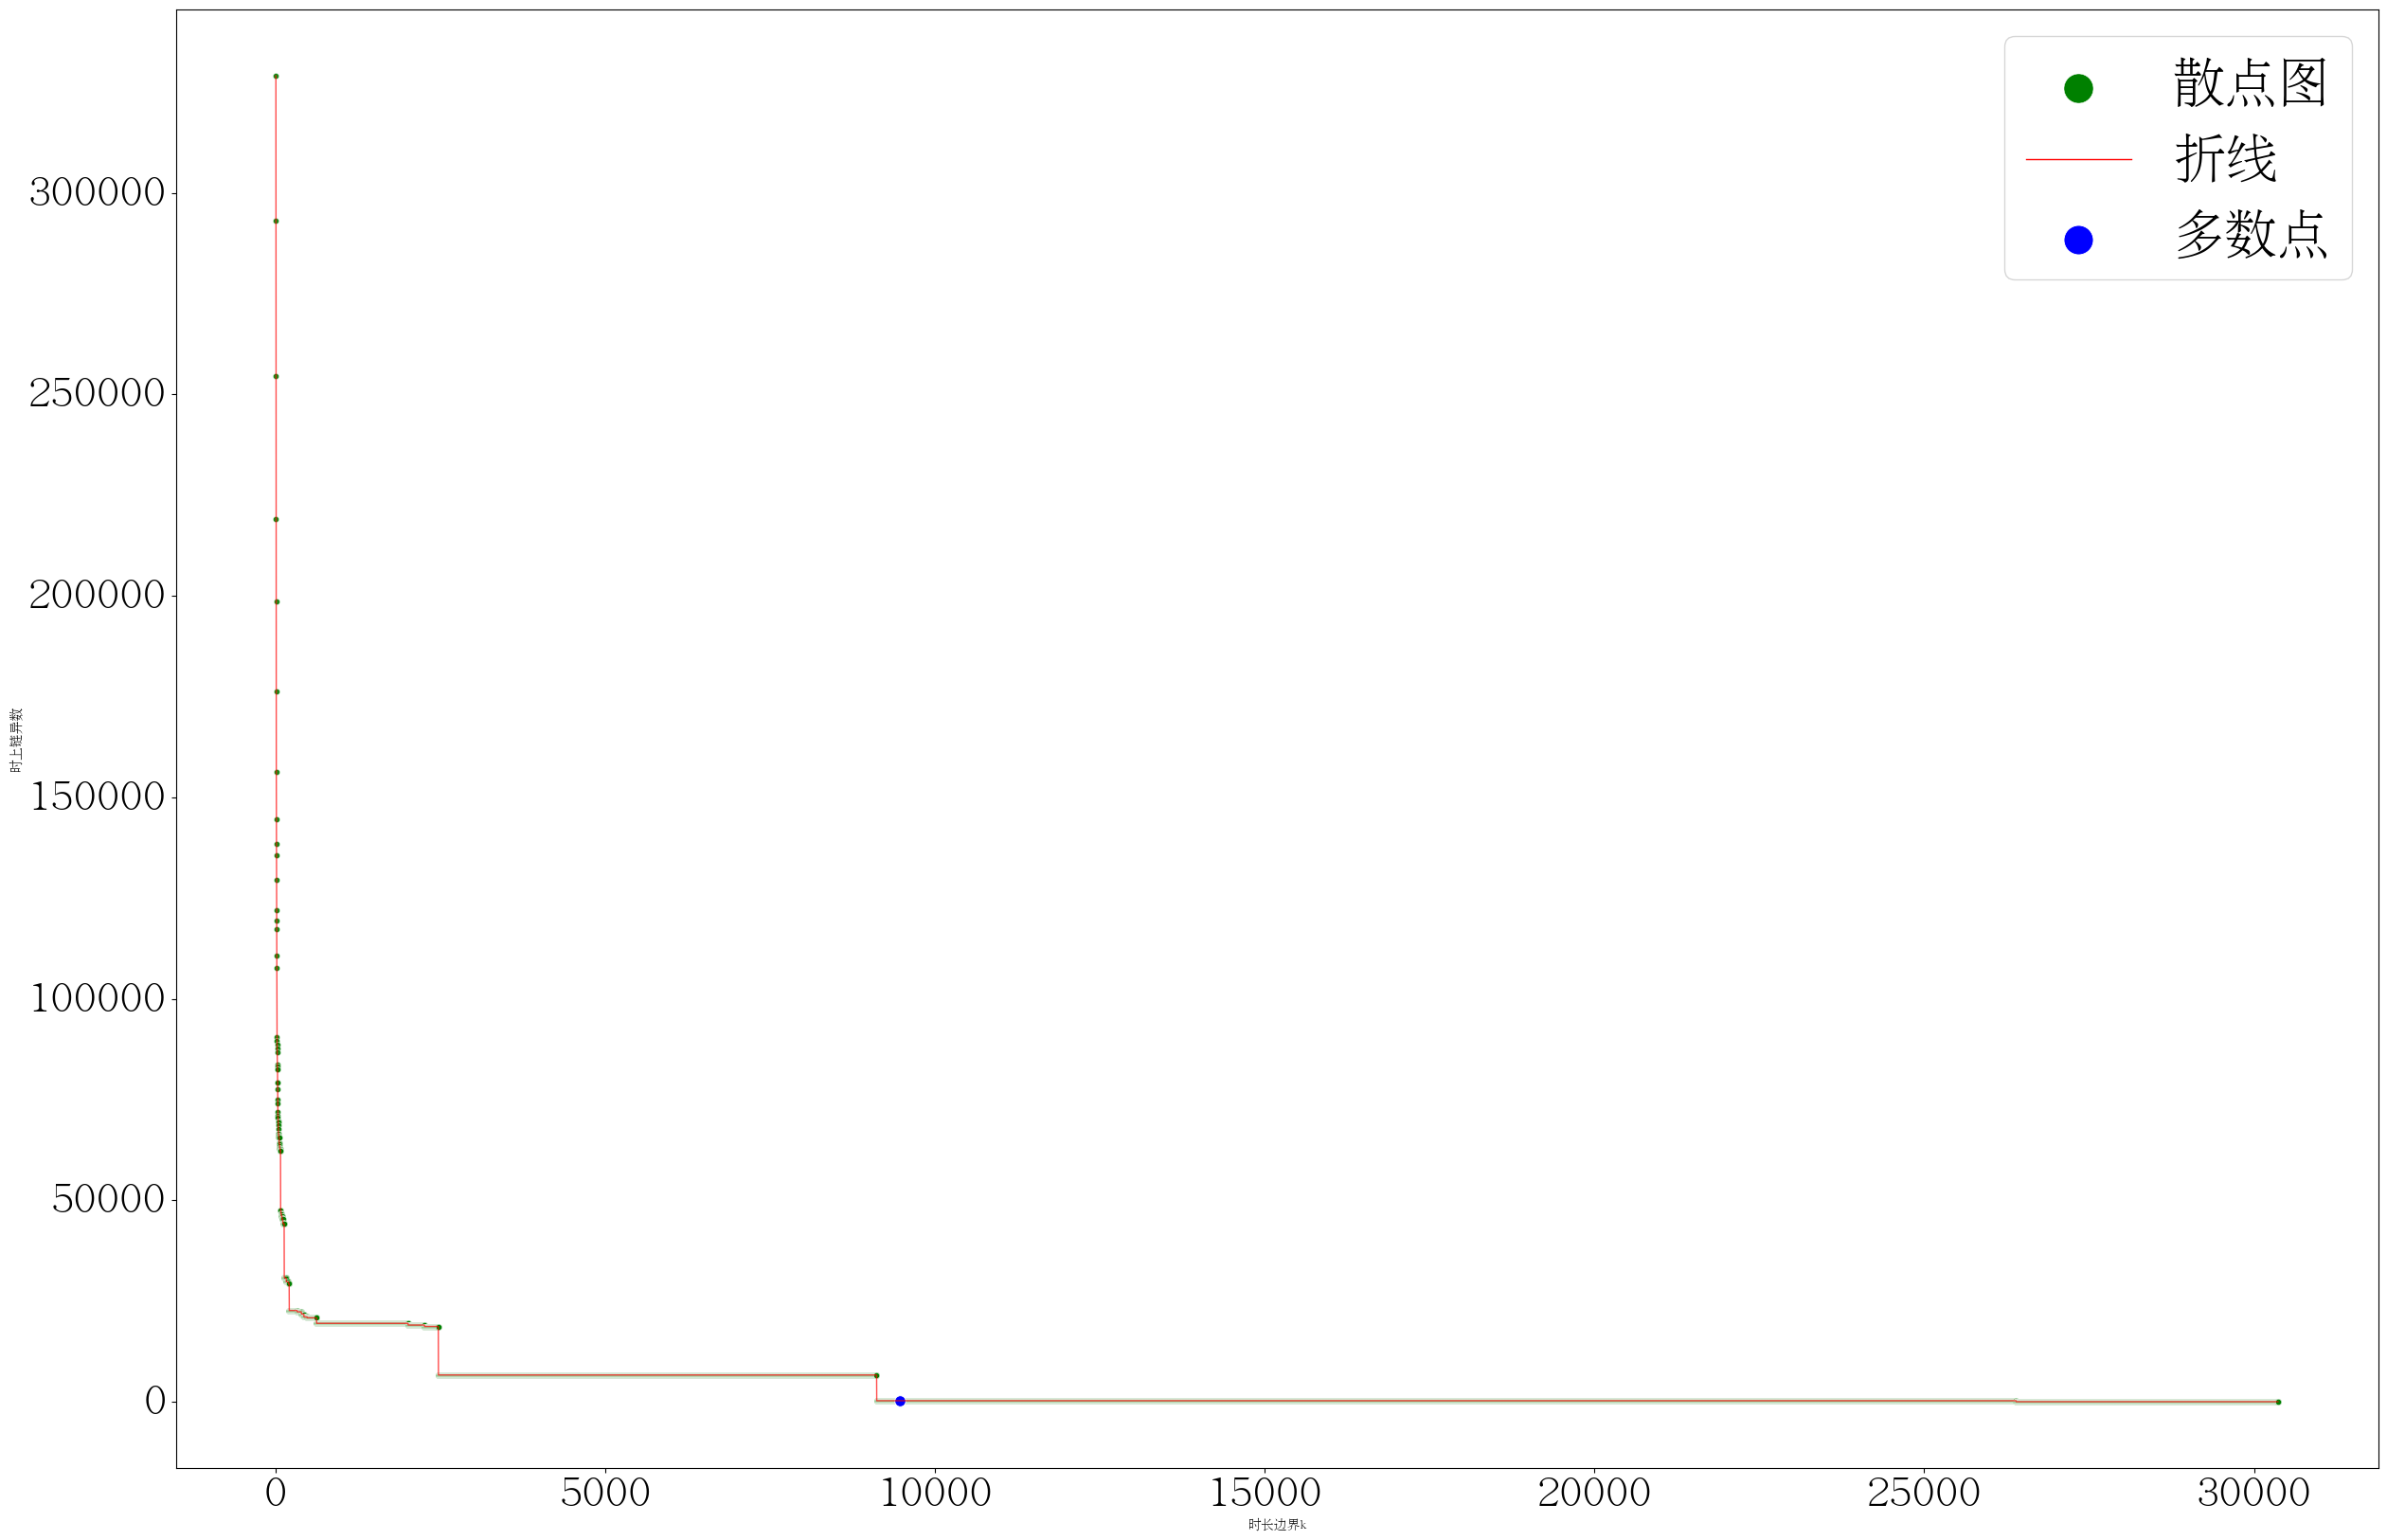

In [42]:

fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.set_xlabel('时长边界k')
ax.set_ylabel('时上链异数')

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x=时长边界们, y=时上链异数们 ,  alpha=0.9, s=20, label='散点图',color='green',ax=ax)  
g2=seaborn.lineplot(x=时长边界们, y=时上链异数们 ,   alpha=0.7, linewidth=1, label='折线',color='red',ax=ax)  


多数点df = pandas.DataFrame({'时长边界': [多数点_时长边界_底], '时上链异数': [ 多数点_时上链异数 ]})
g3=seaborn.scatterplot(data=多数点df, x='时长边界', y='时上链异数', s=70, label='多数点',color='blue',ax=ax)

inrease_g_size(g1)
inrease_g_size(g2)
inrease_g_size(g3)



####  3.5  只 保留 函数本地时长 较大的 日志们

>  df进出、df链、df出 只 保留 函数本地时长 较大的

In [43]:

df进出=df进出[  df进出['funcId'].isin( 本地时长funId们 )  ]

df链=df链[  df链['funcId'].isin( 本地时长funId们 )  ]

df出=df出[  df出['funcId'].isin( 本地时长funId们 )  ]


In [44]:
df进出.shape,df链.shape,df出.shape

((58588, 24), (29294, 24), (29294, 24))

# 4 作图

###  栈生、栈净、栈死

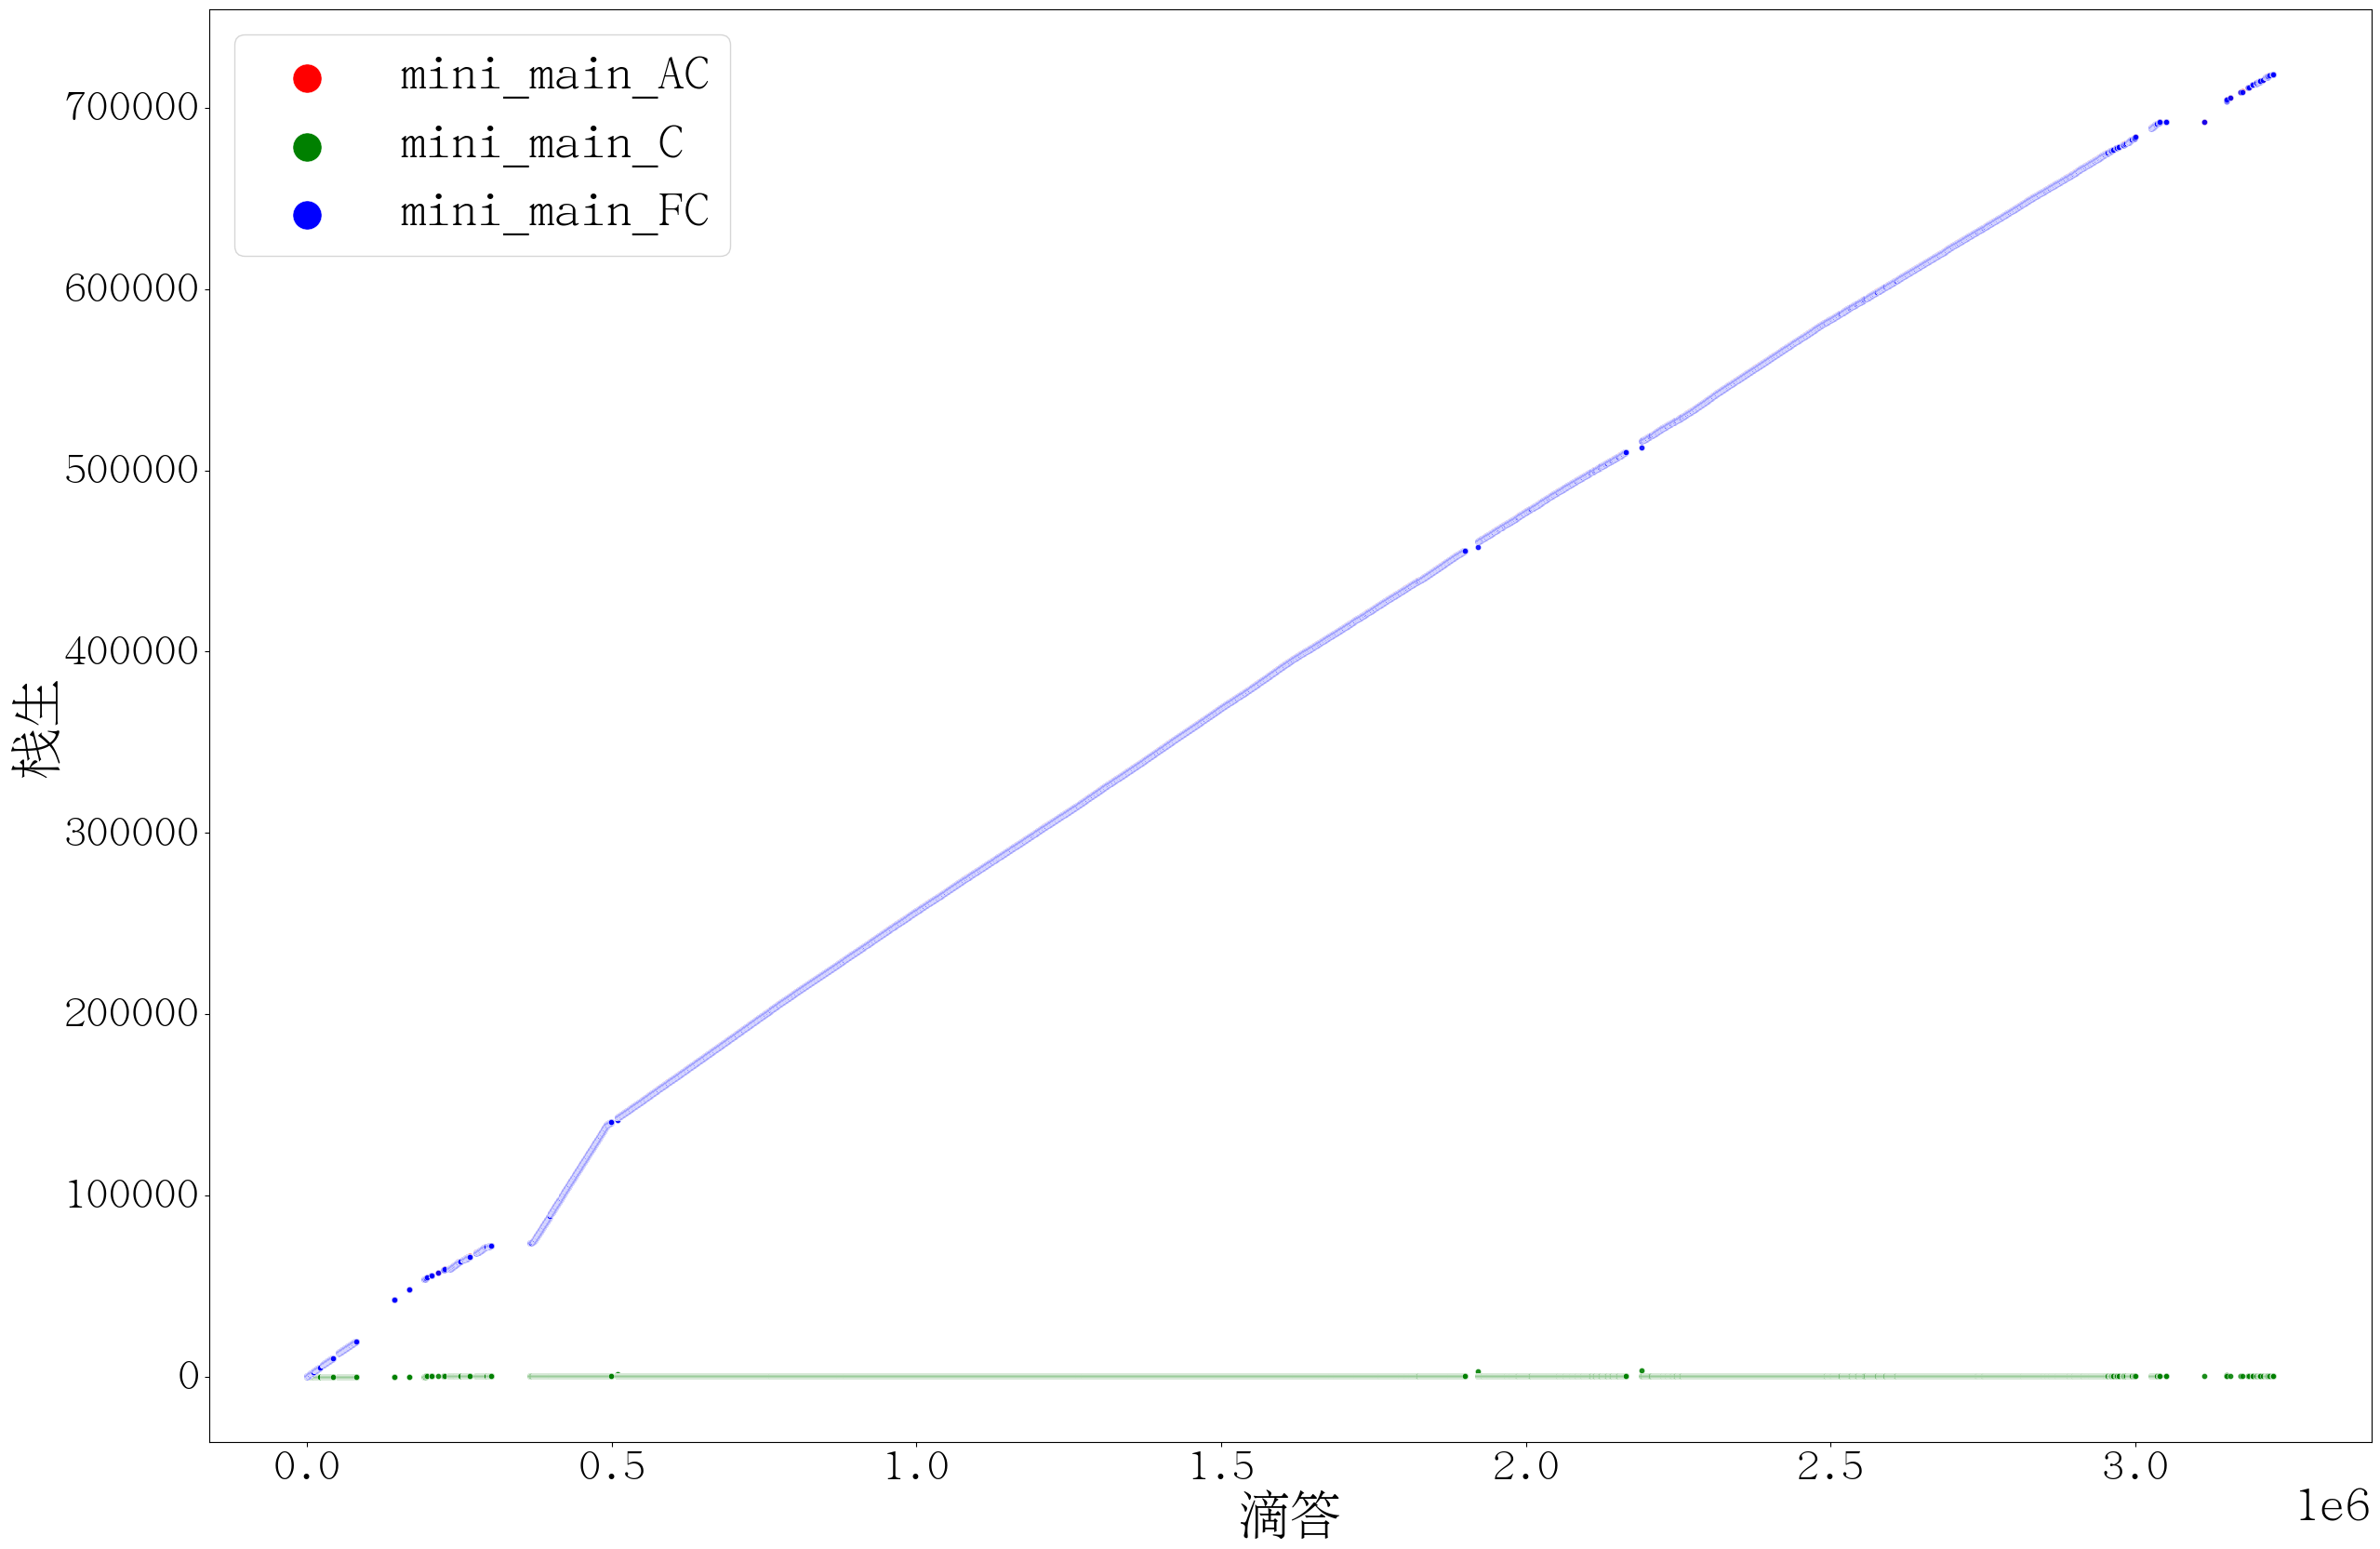

In [45]:

fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈生' , data=df进出, alpha=0.9, s=20, label='mini_main_AC',color='red',ax=ax)  
g2=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='mini_main_C',color='green',ax=ax)   
g3=seaborn.scatterplot(x='滴答', y='栈死' , data=df进出, alpha=0.9, s=20, label='mini_main_FC',color='blue',ax=ax)   

inrease_g_size(g1)
inrease_g_size(g2)
inrease_g_size(g3)

###  栈净、链长

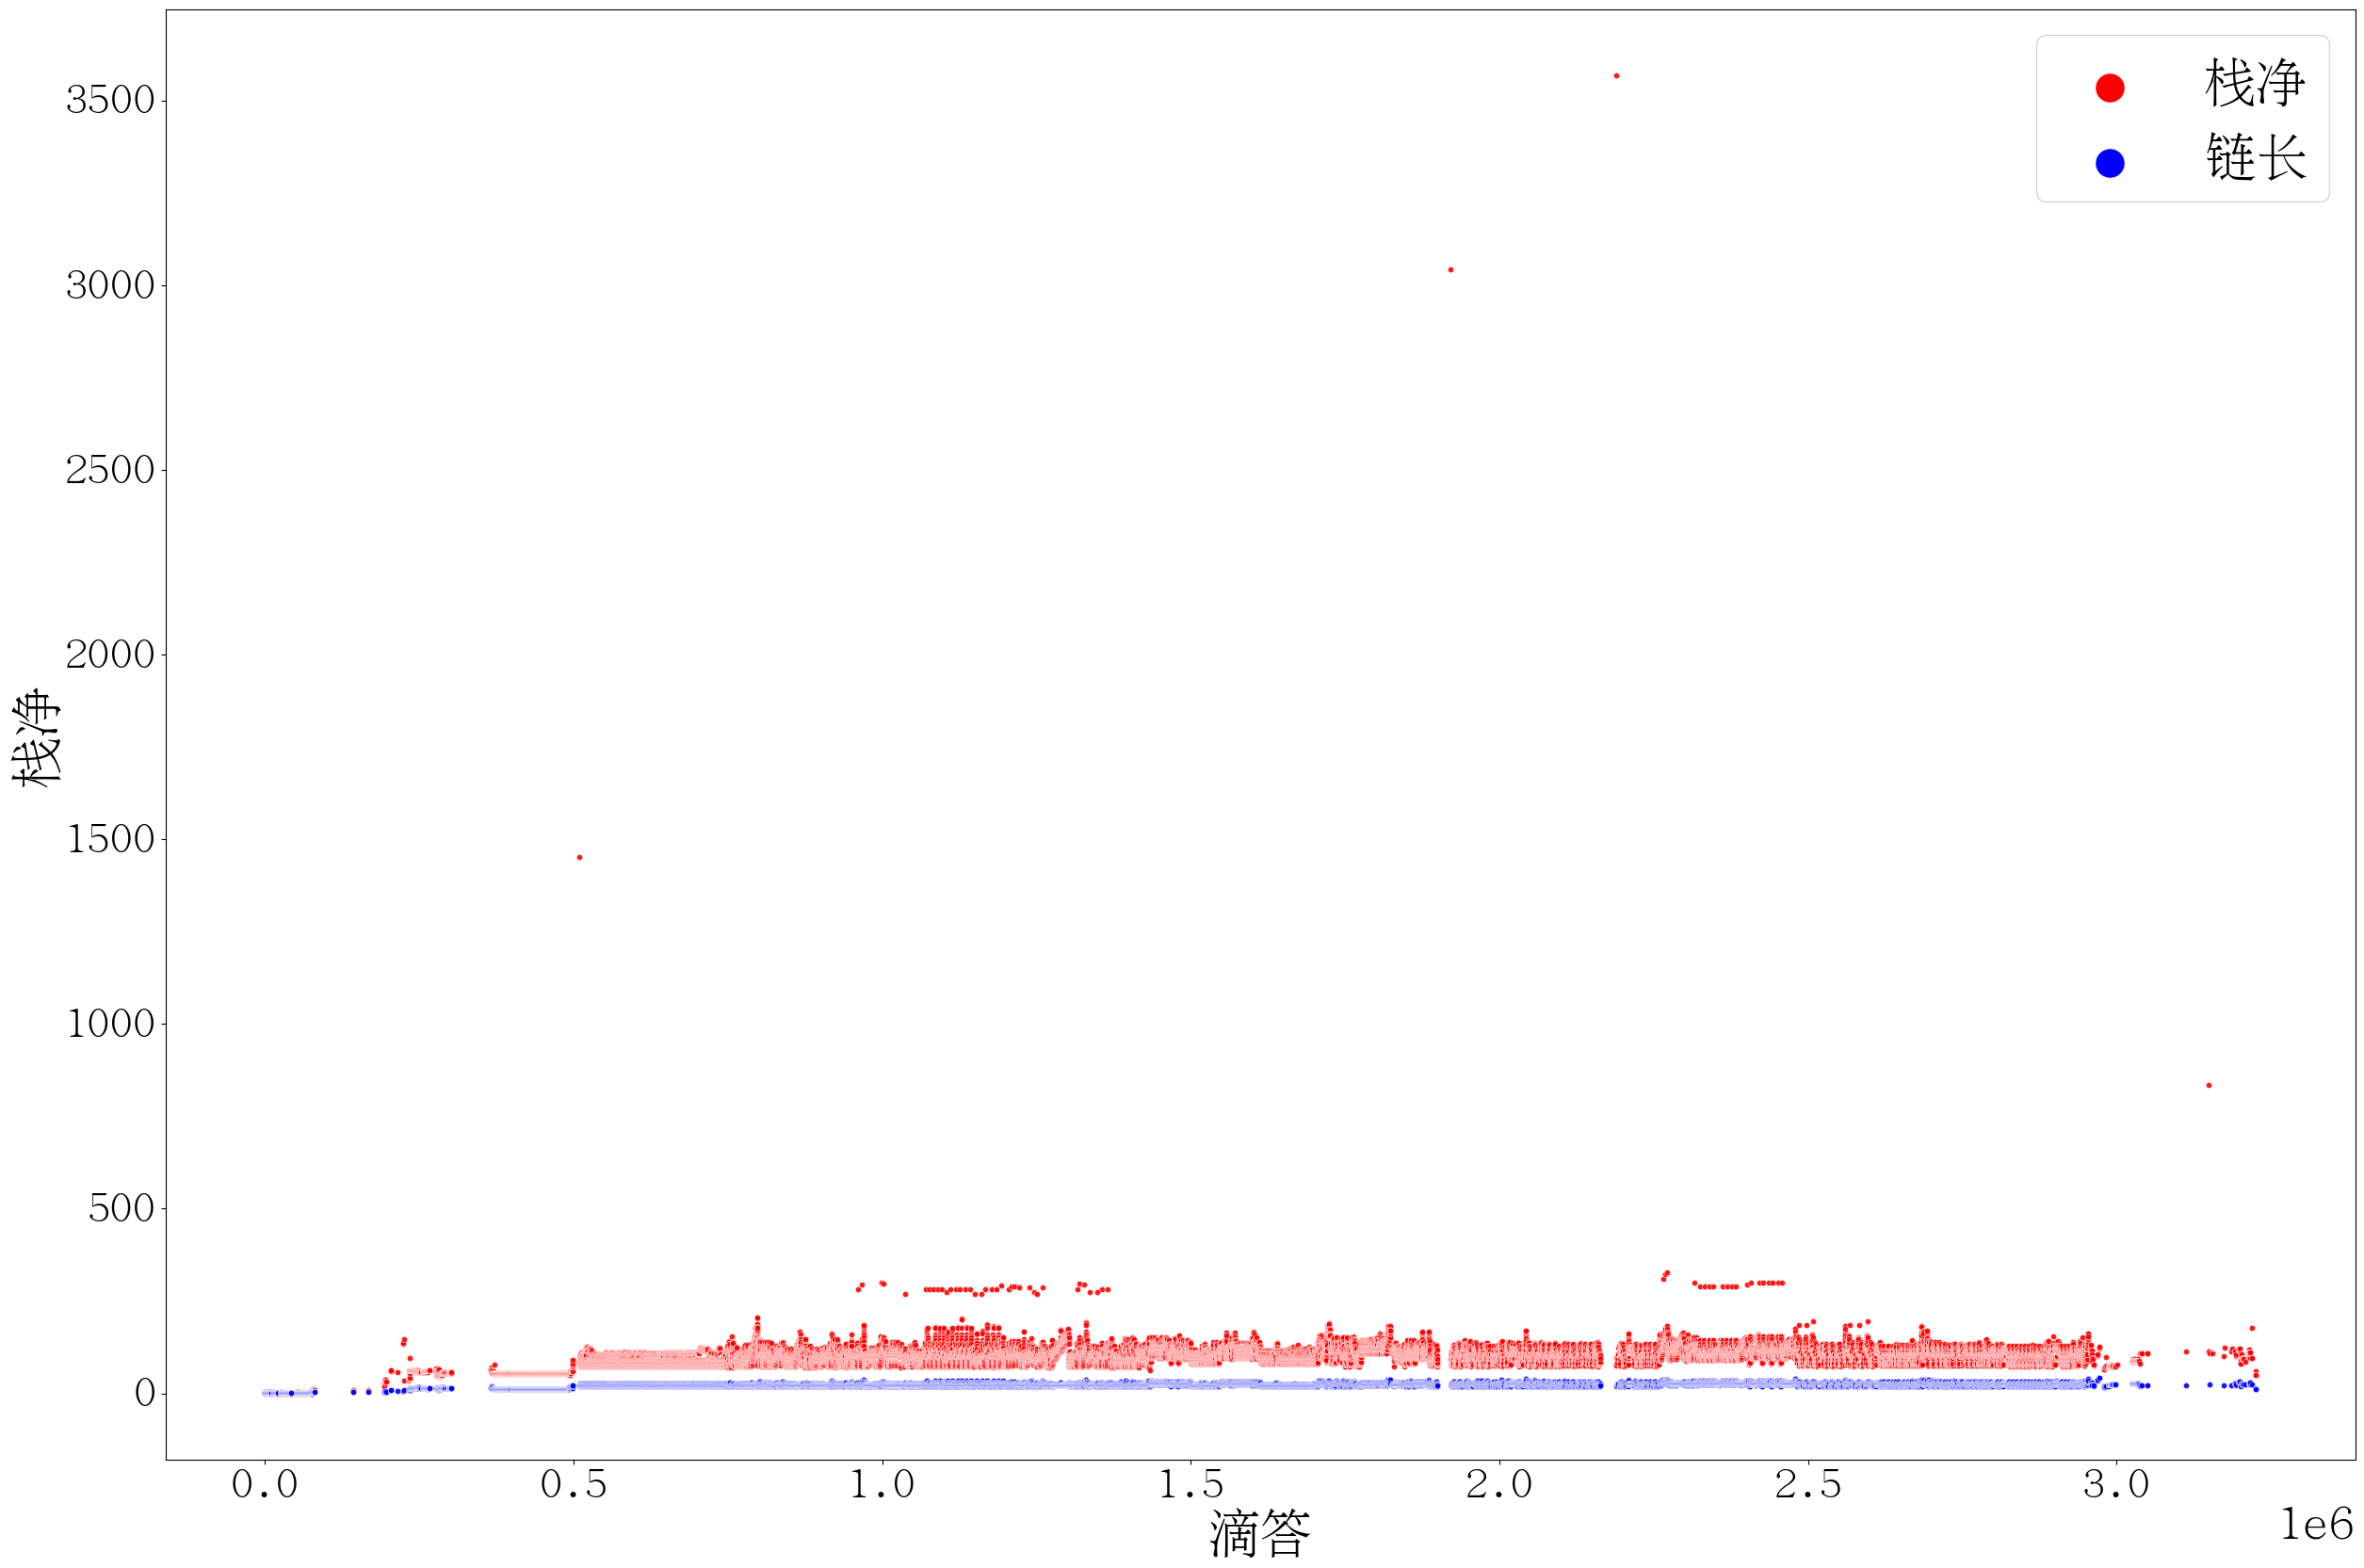

In [46]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x=df进出.滴答, y=df进出.栈净 ,  alpha=0.9, s=20, label='栈净',color='red',ax=ax)  
g2=seaborn.scatterplot(x=df链.滴答, y=df链.funcEnterIdSeqLen, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

从上图看出，栈净 250 以上的点 导致图很难看，因此250以上削成平顶

###  栈净平顶、链长

In [47]:
df进出['栈净平顶']=df进出.栈净.apply(lambda k:min(k,250))

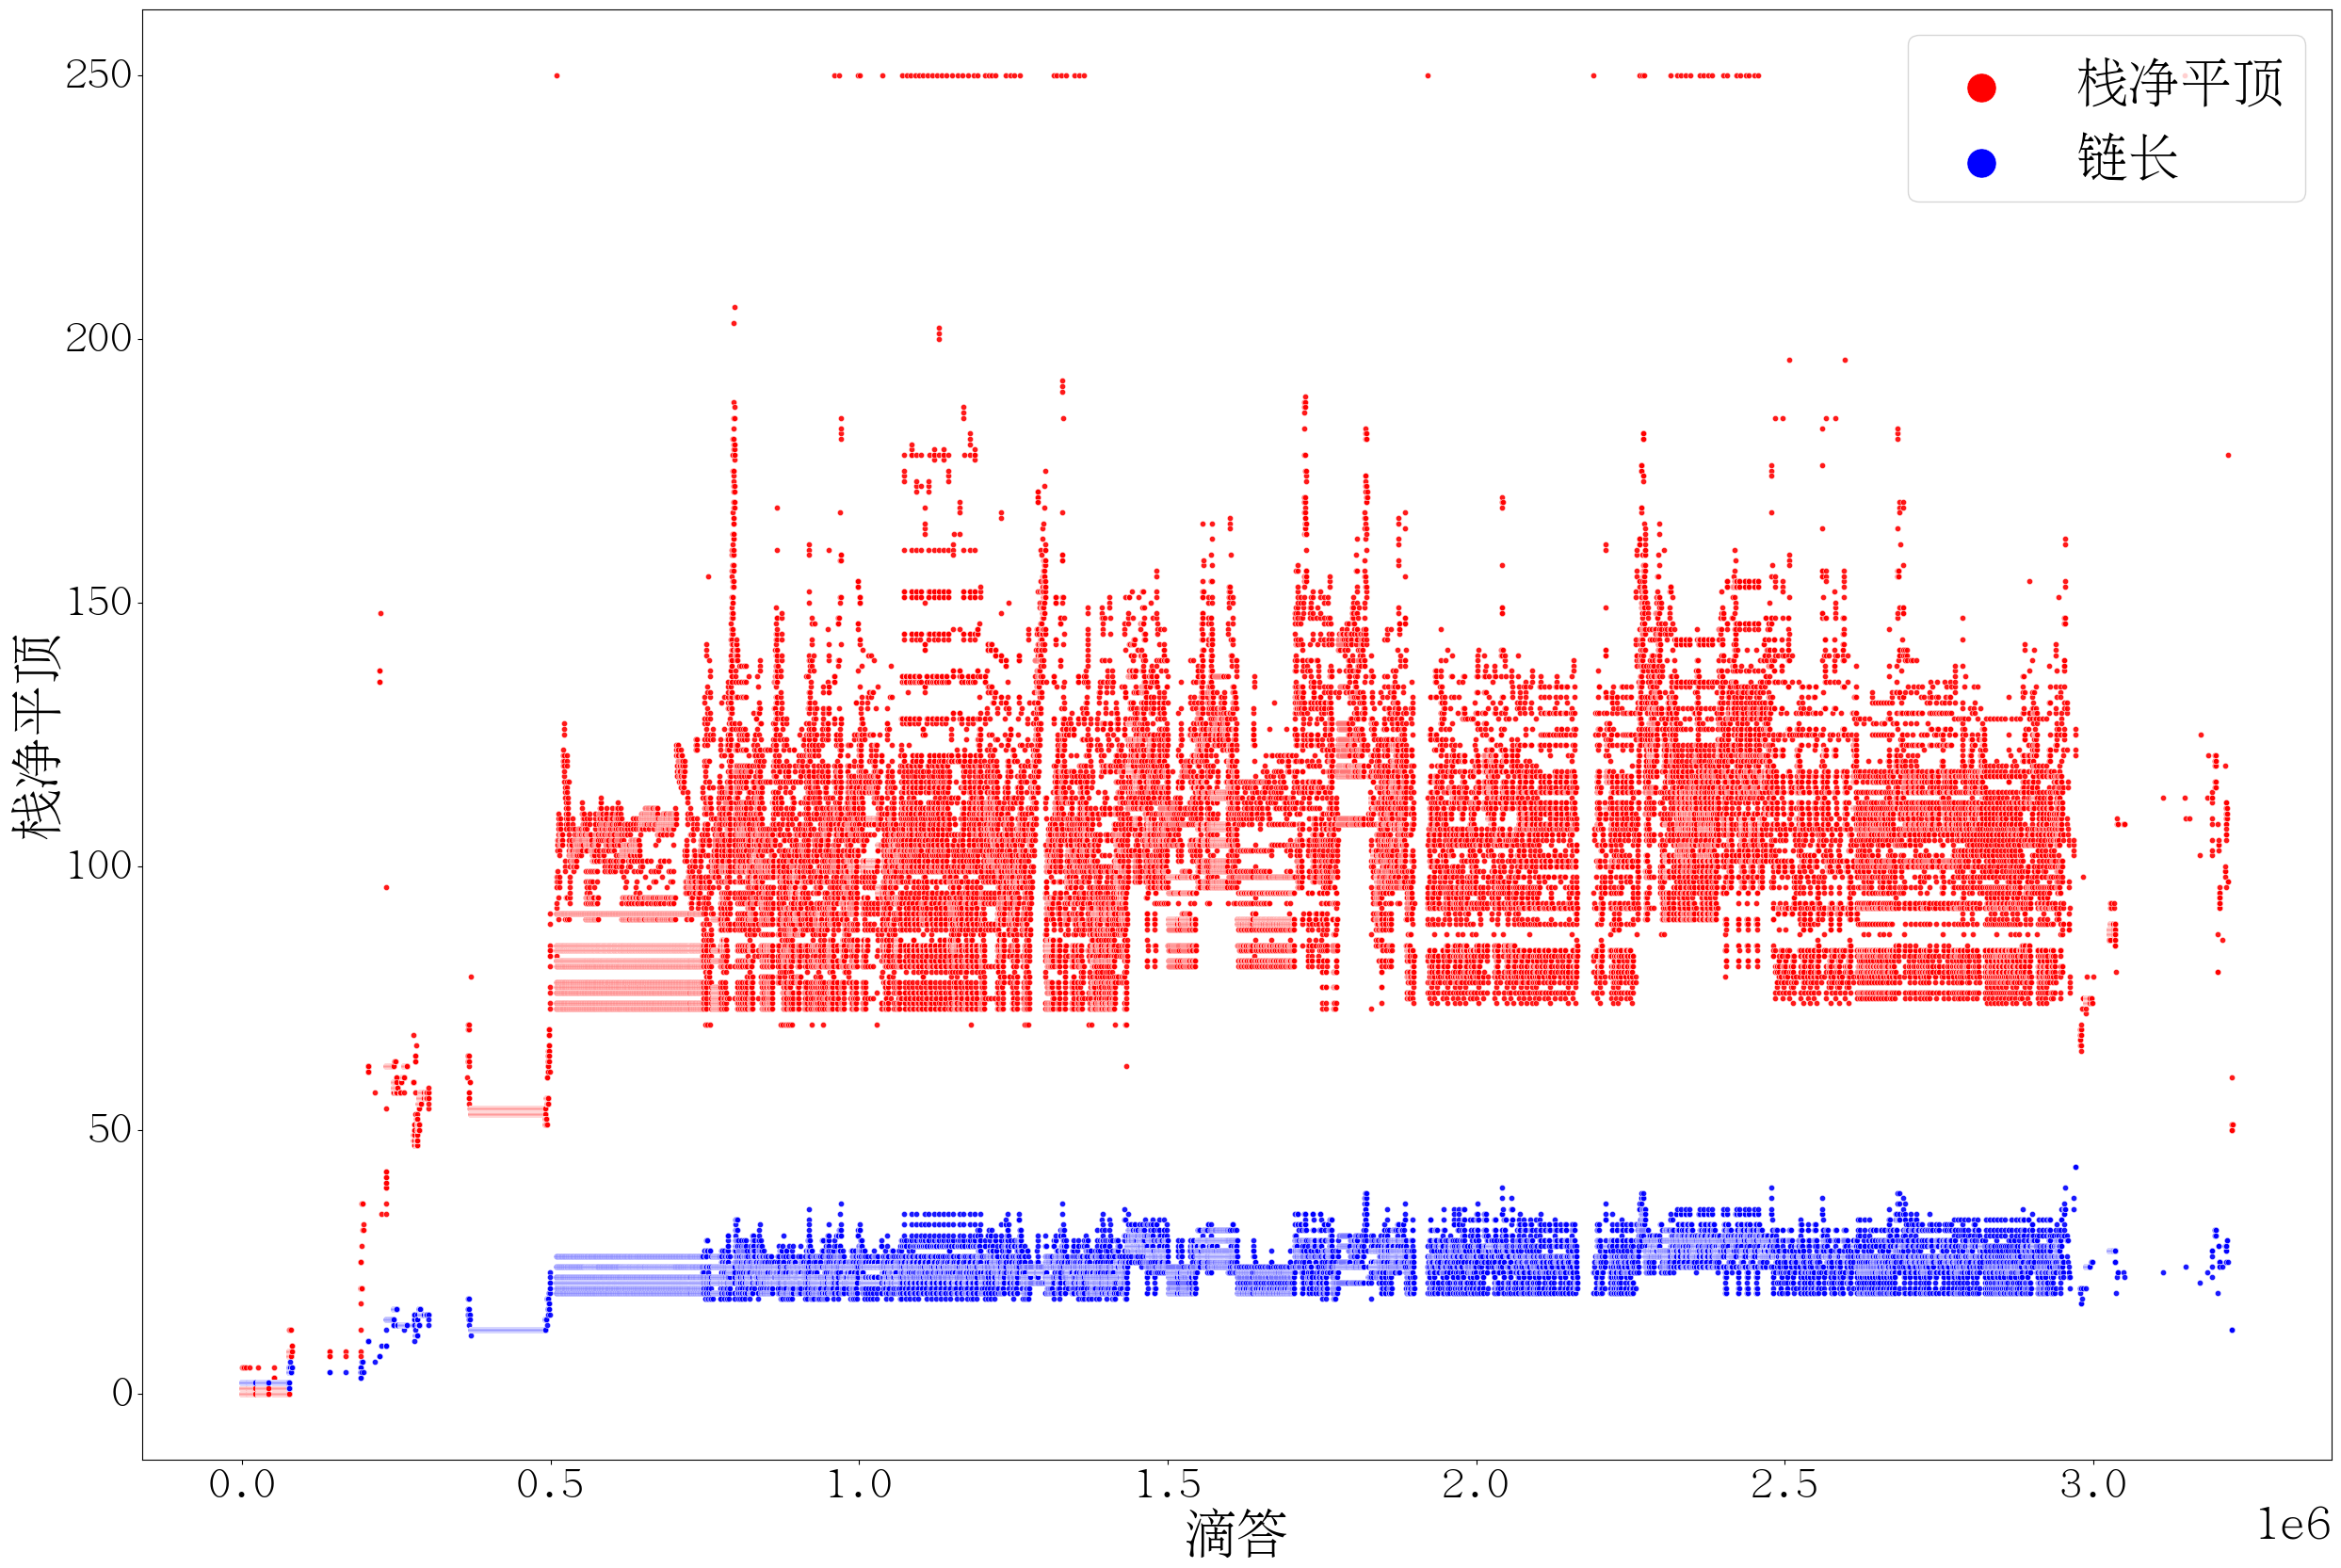

In [48]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
# matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x=df进出.滴答, y=df进出.栈净平顶 ,   alpha=0.9, s=20, label='栈净平顶',color='red',ax=ax)  
g2=seaborn.scatterplot(x=df链.滴答, y=df链.funcEnterIdSeqLen ,  alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

###  归一化：栈净平顶、链长

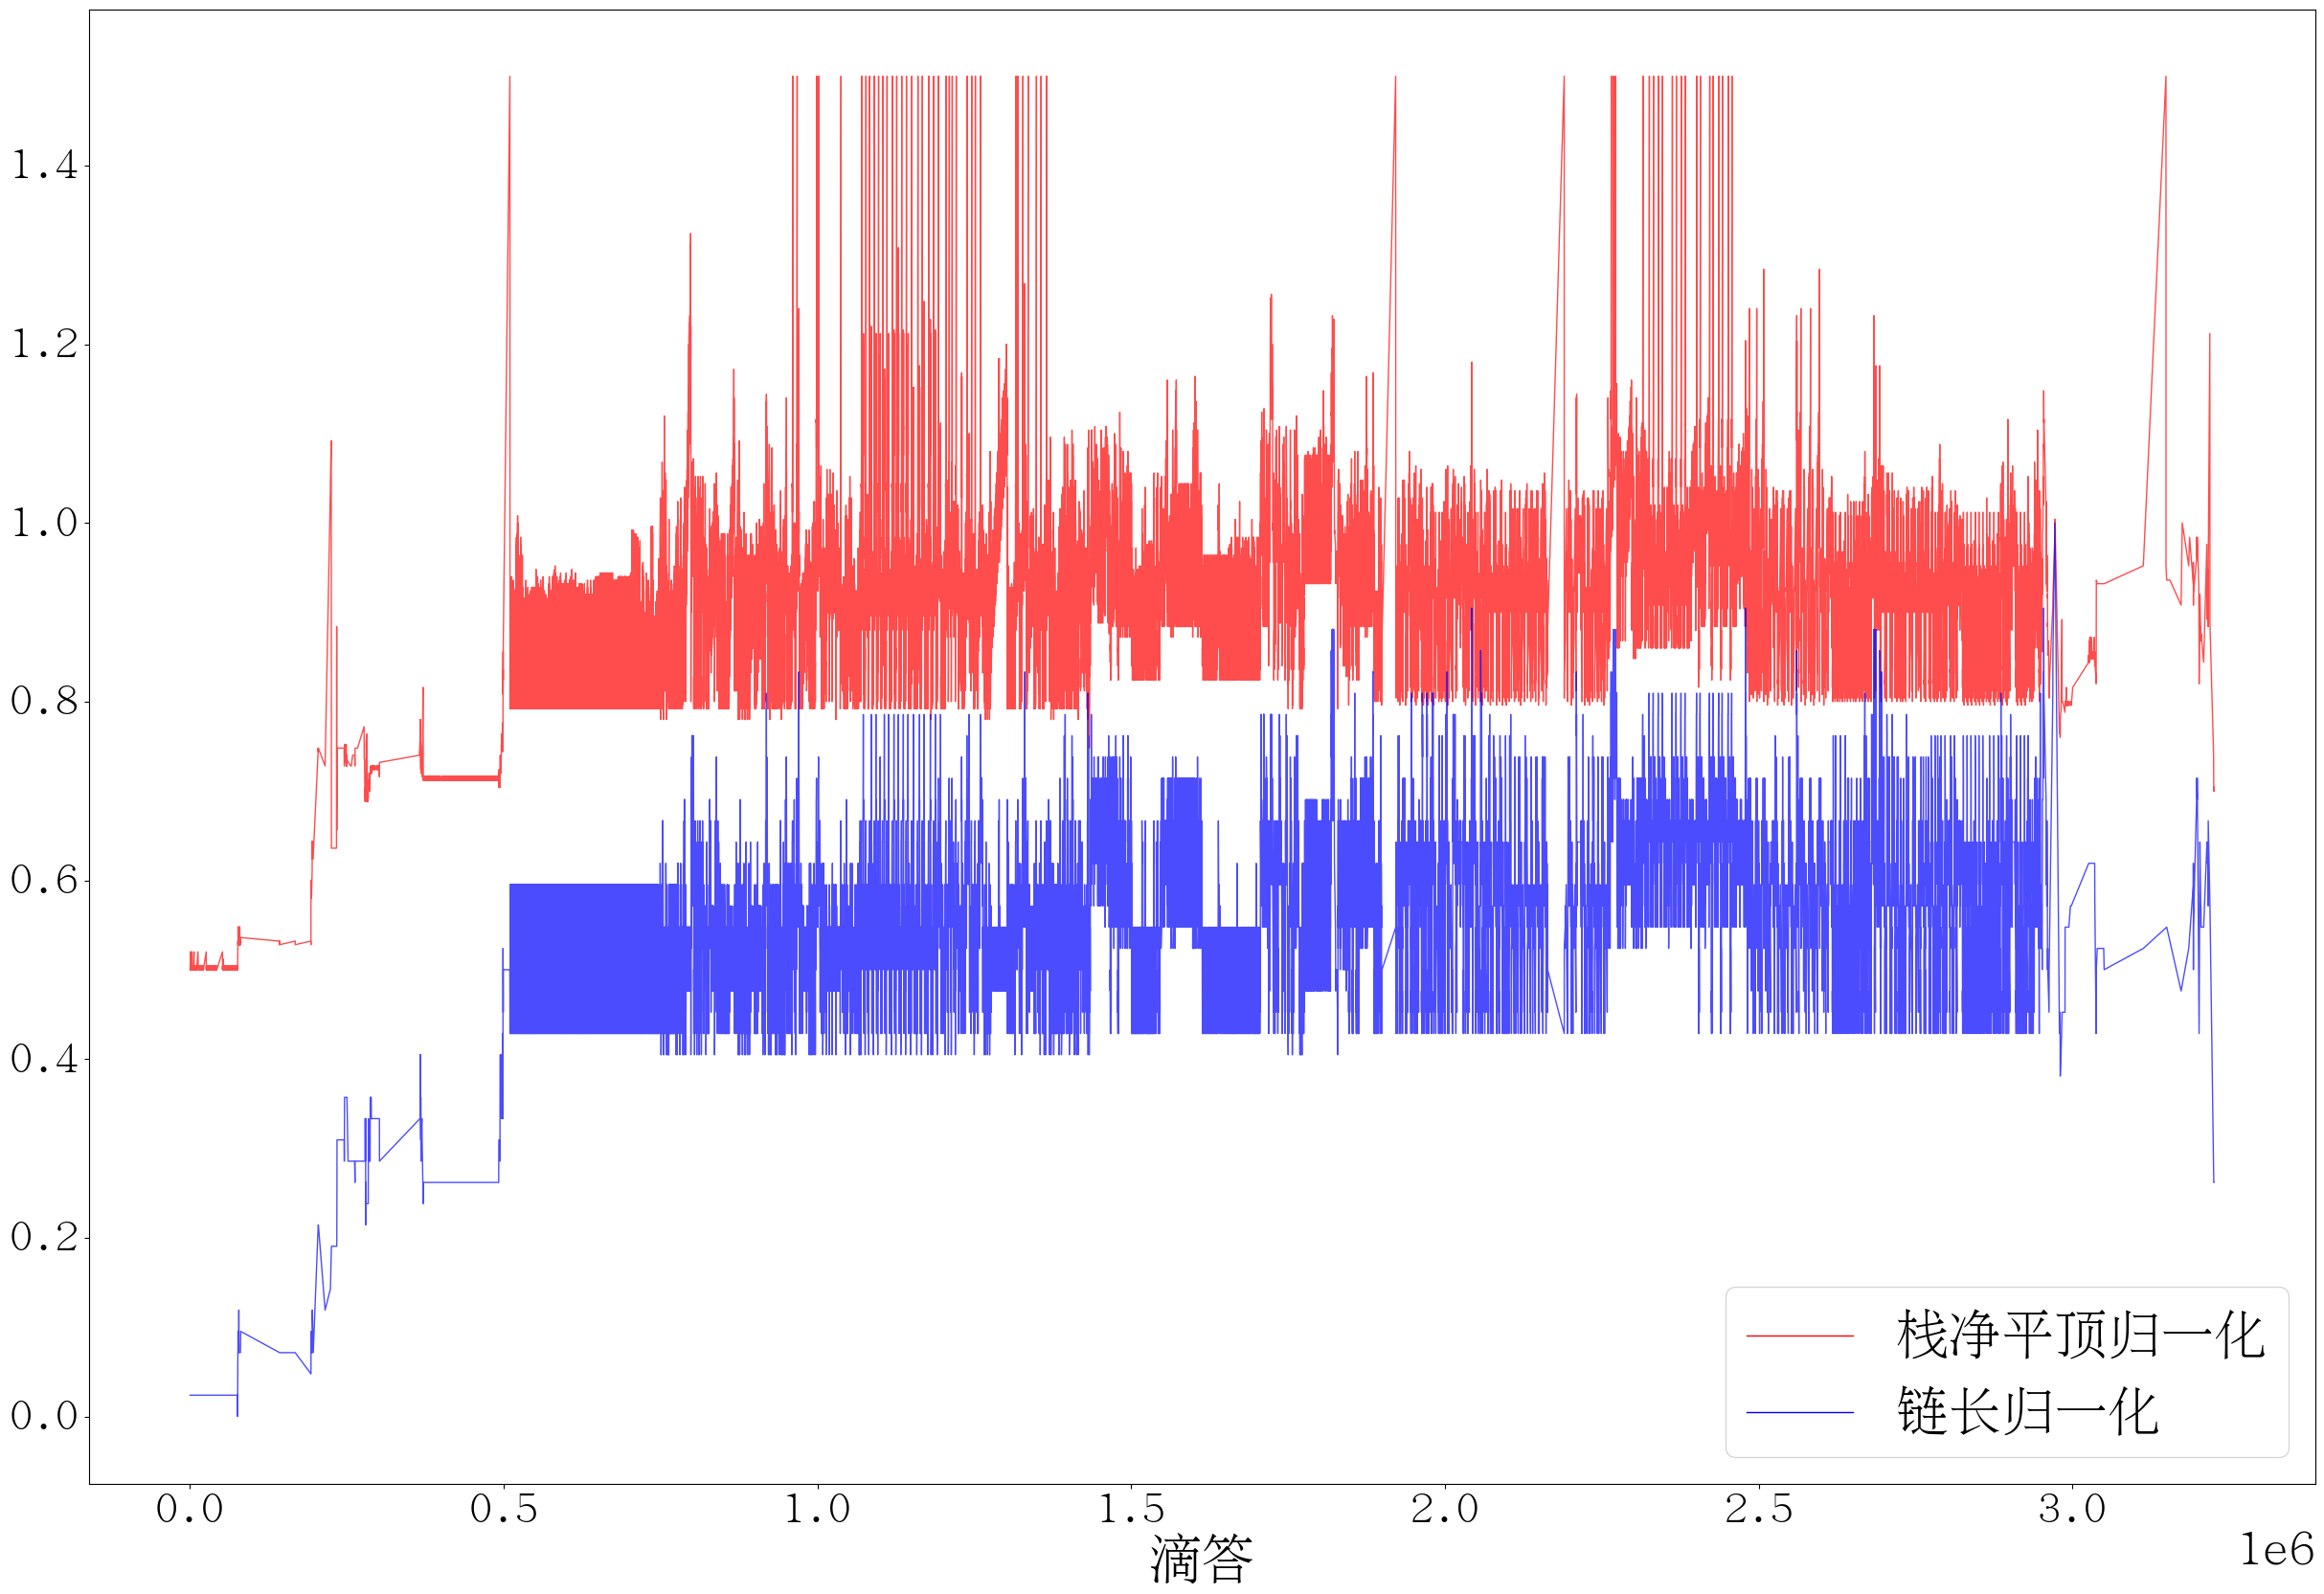

In [49]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
# matplotlib.pyplot.rcParams['font.size'] = 40

_y1Scaler=minMaxScaler.fit_transform( df进出[['栈净平顶']] ).flatten()
#经过观察，整体向上移动0.5 可以使得两个图像不重叠，且方便对比
g1=seaborn.lineplot(x=df进出.滴答, y=_y1Scaler+0.5 ,   alpha=0.7, linewidth=1, label='栈净平顶归一化',color='red',ax=ax)  

_y2Scaler=minMaxScaler.fit_transform( df链[['funcEnterIdSeqLen']] ).flatten()
g2=seaborn.lineplot(x=df链.滴答, y=_y2Scaler,  alpha=0.7, linewidth=1, label='链长归一化',color='blue',ax=ax)  


inrease_g_size(g1)
inrease_g_size(g2)

###  栈净：散点、折线

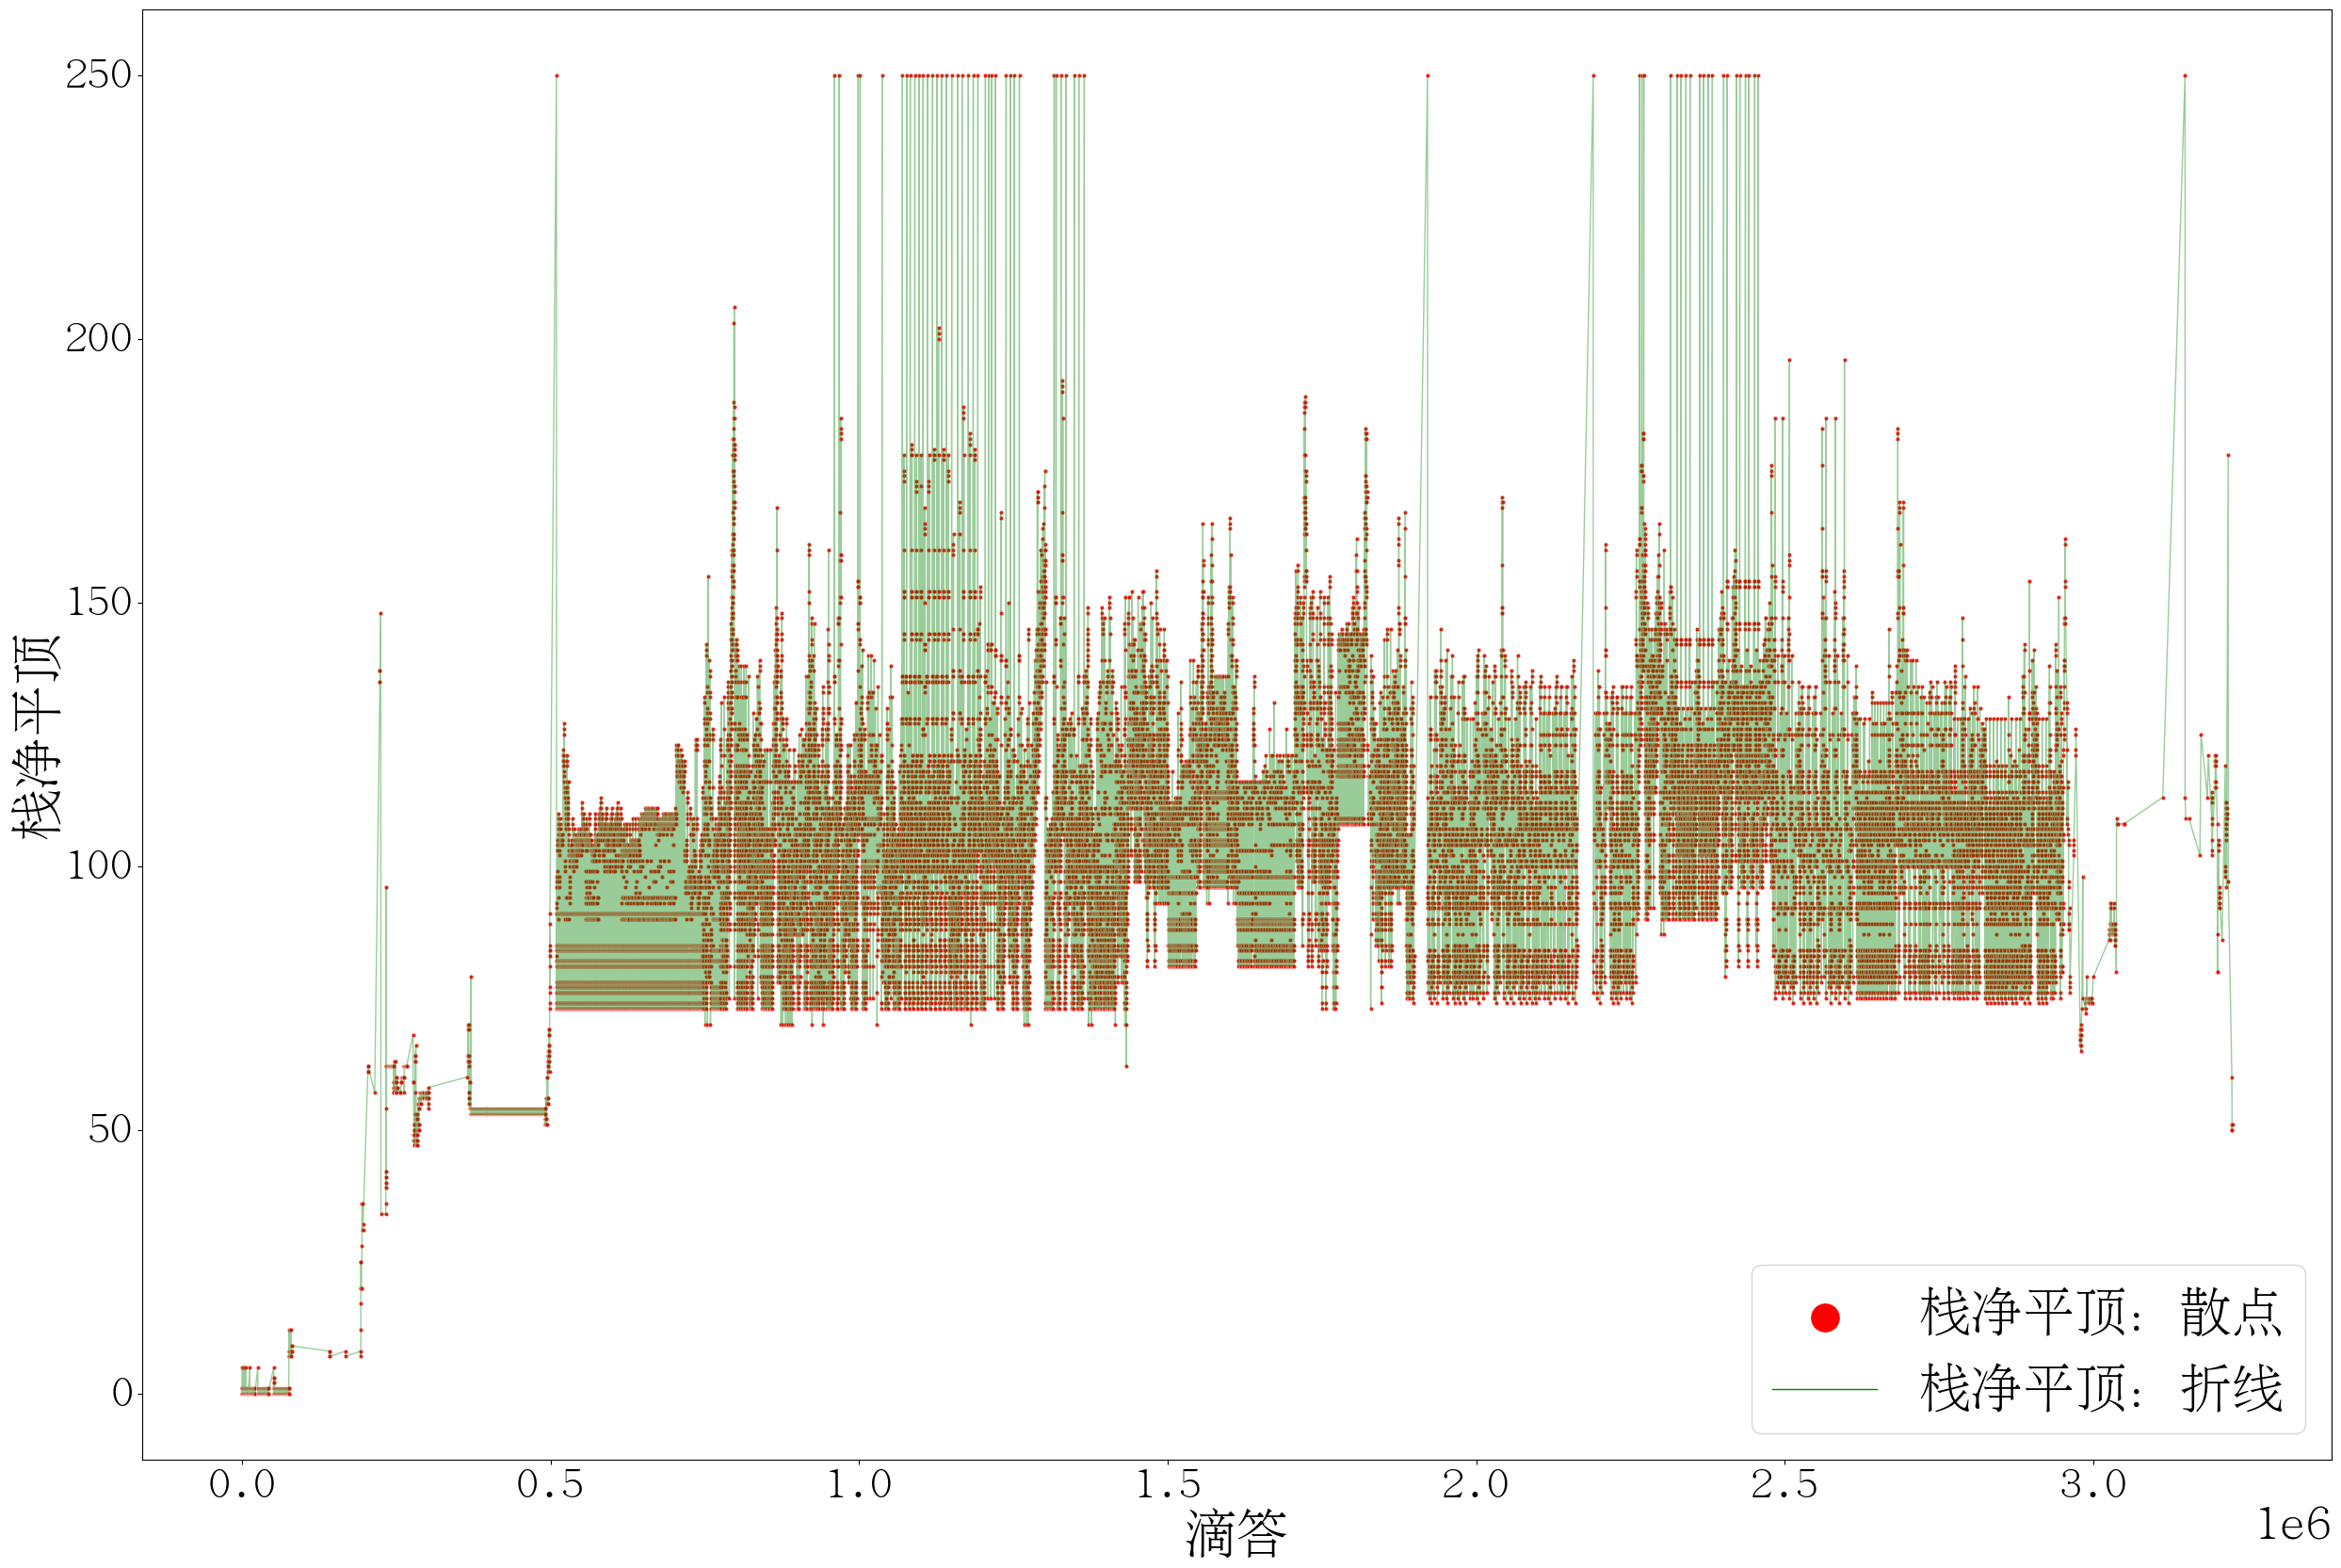

In [50]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净平顶' , data=df进出, alpha=0.9, s=10, label='栈净平顶：散点',color='red',ax=ax)  
g2=seaborn.lineplot(x='滴答', y='栈净平顶' , data=df进出, alpha=0.4, linewidth=1, label='栈净平顶：折线',color='green',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

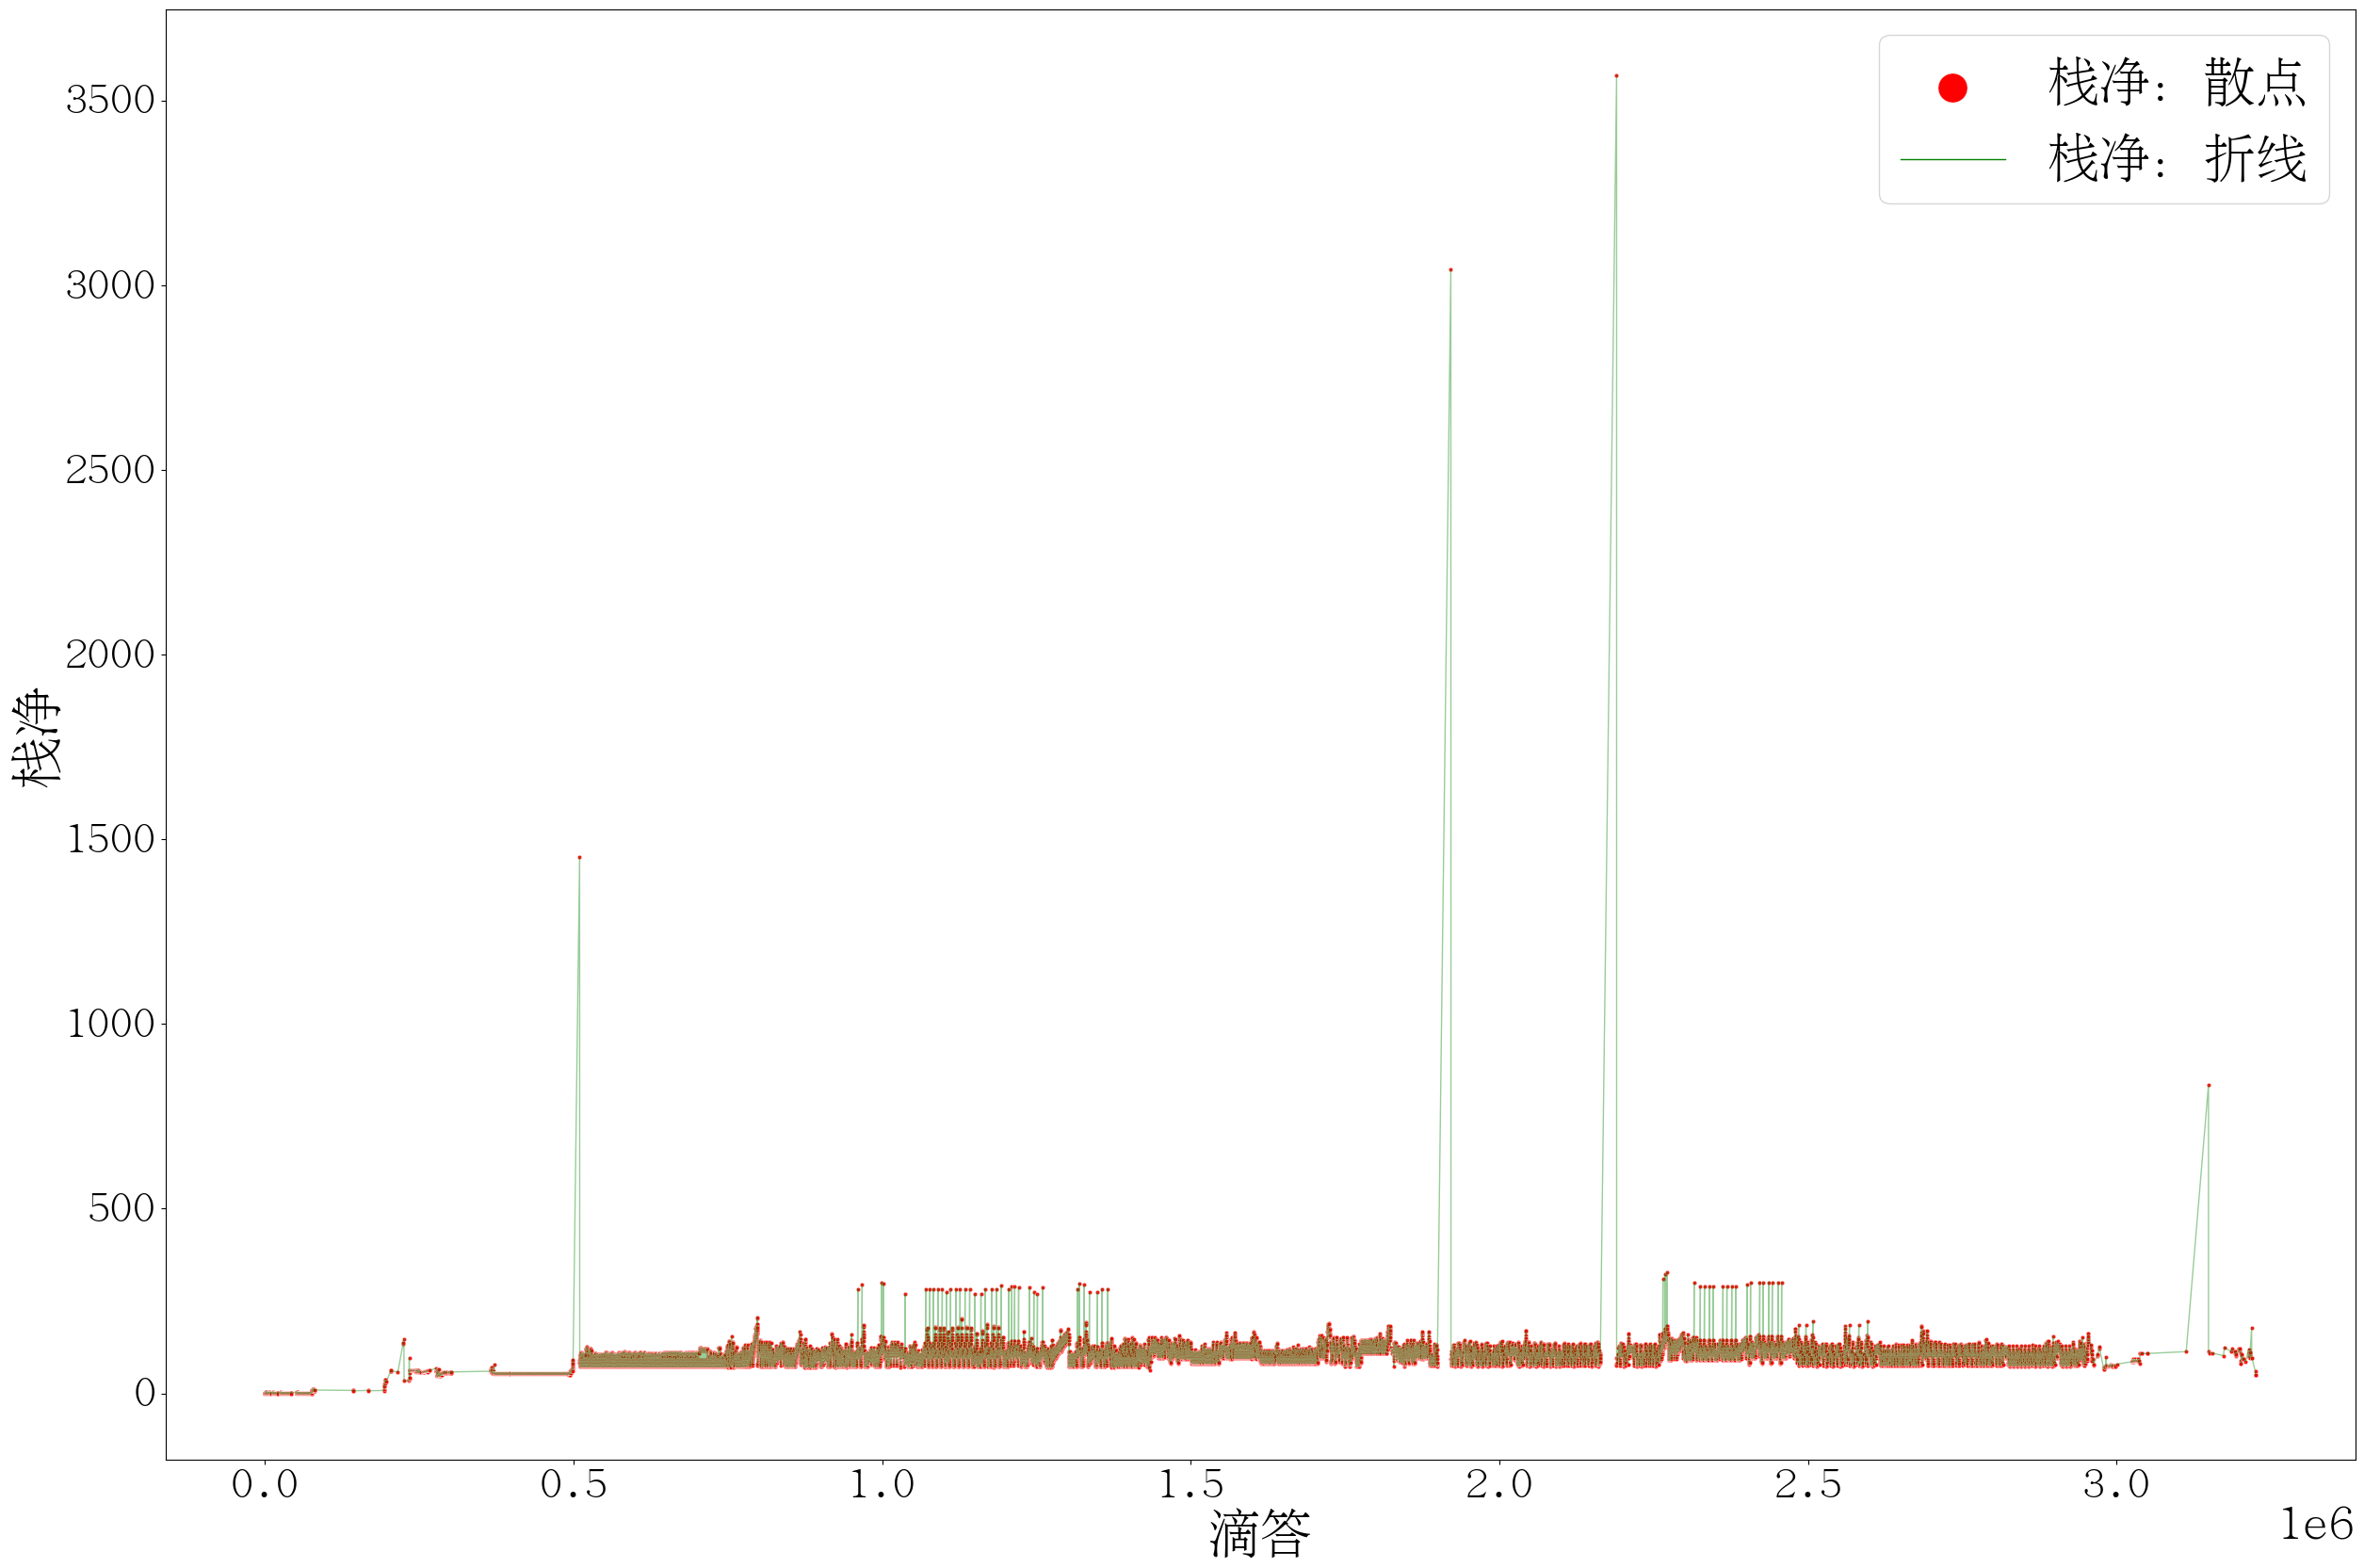

In [51]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=10, label='栈净：散点',color='red',ax=ax)  
g2=seaborn.lineplot(x='滴答', y='栈净' , data=df进出, alpha=0.4, linewidth=1, label='栈净：折线',color='green',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

###  链长：散点、折线

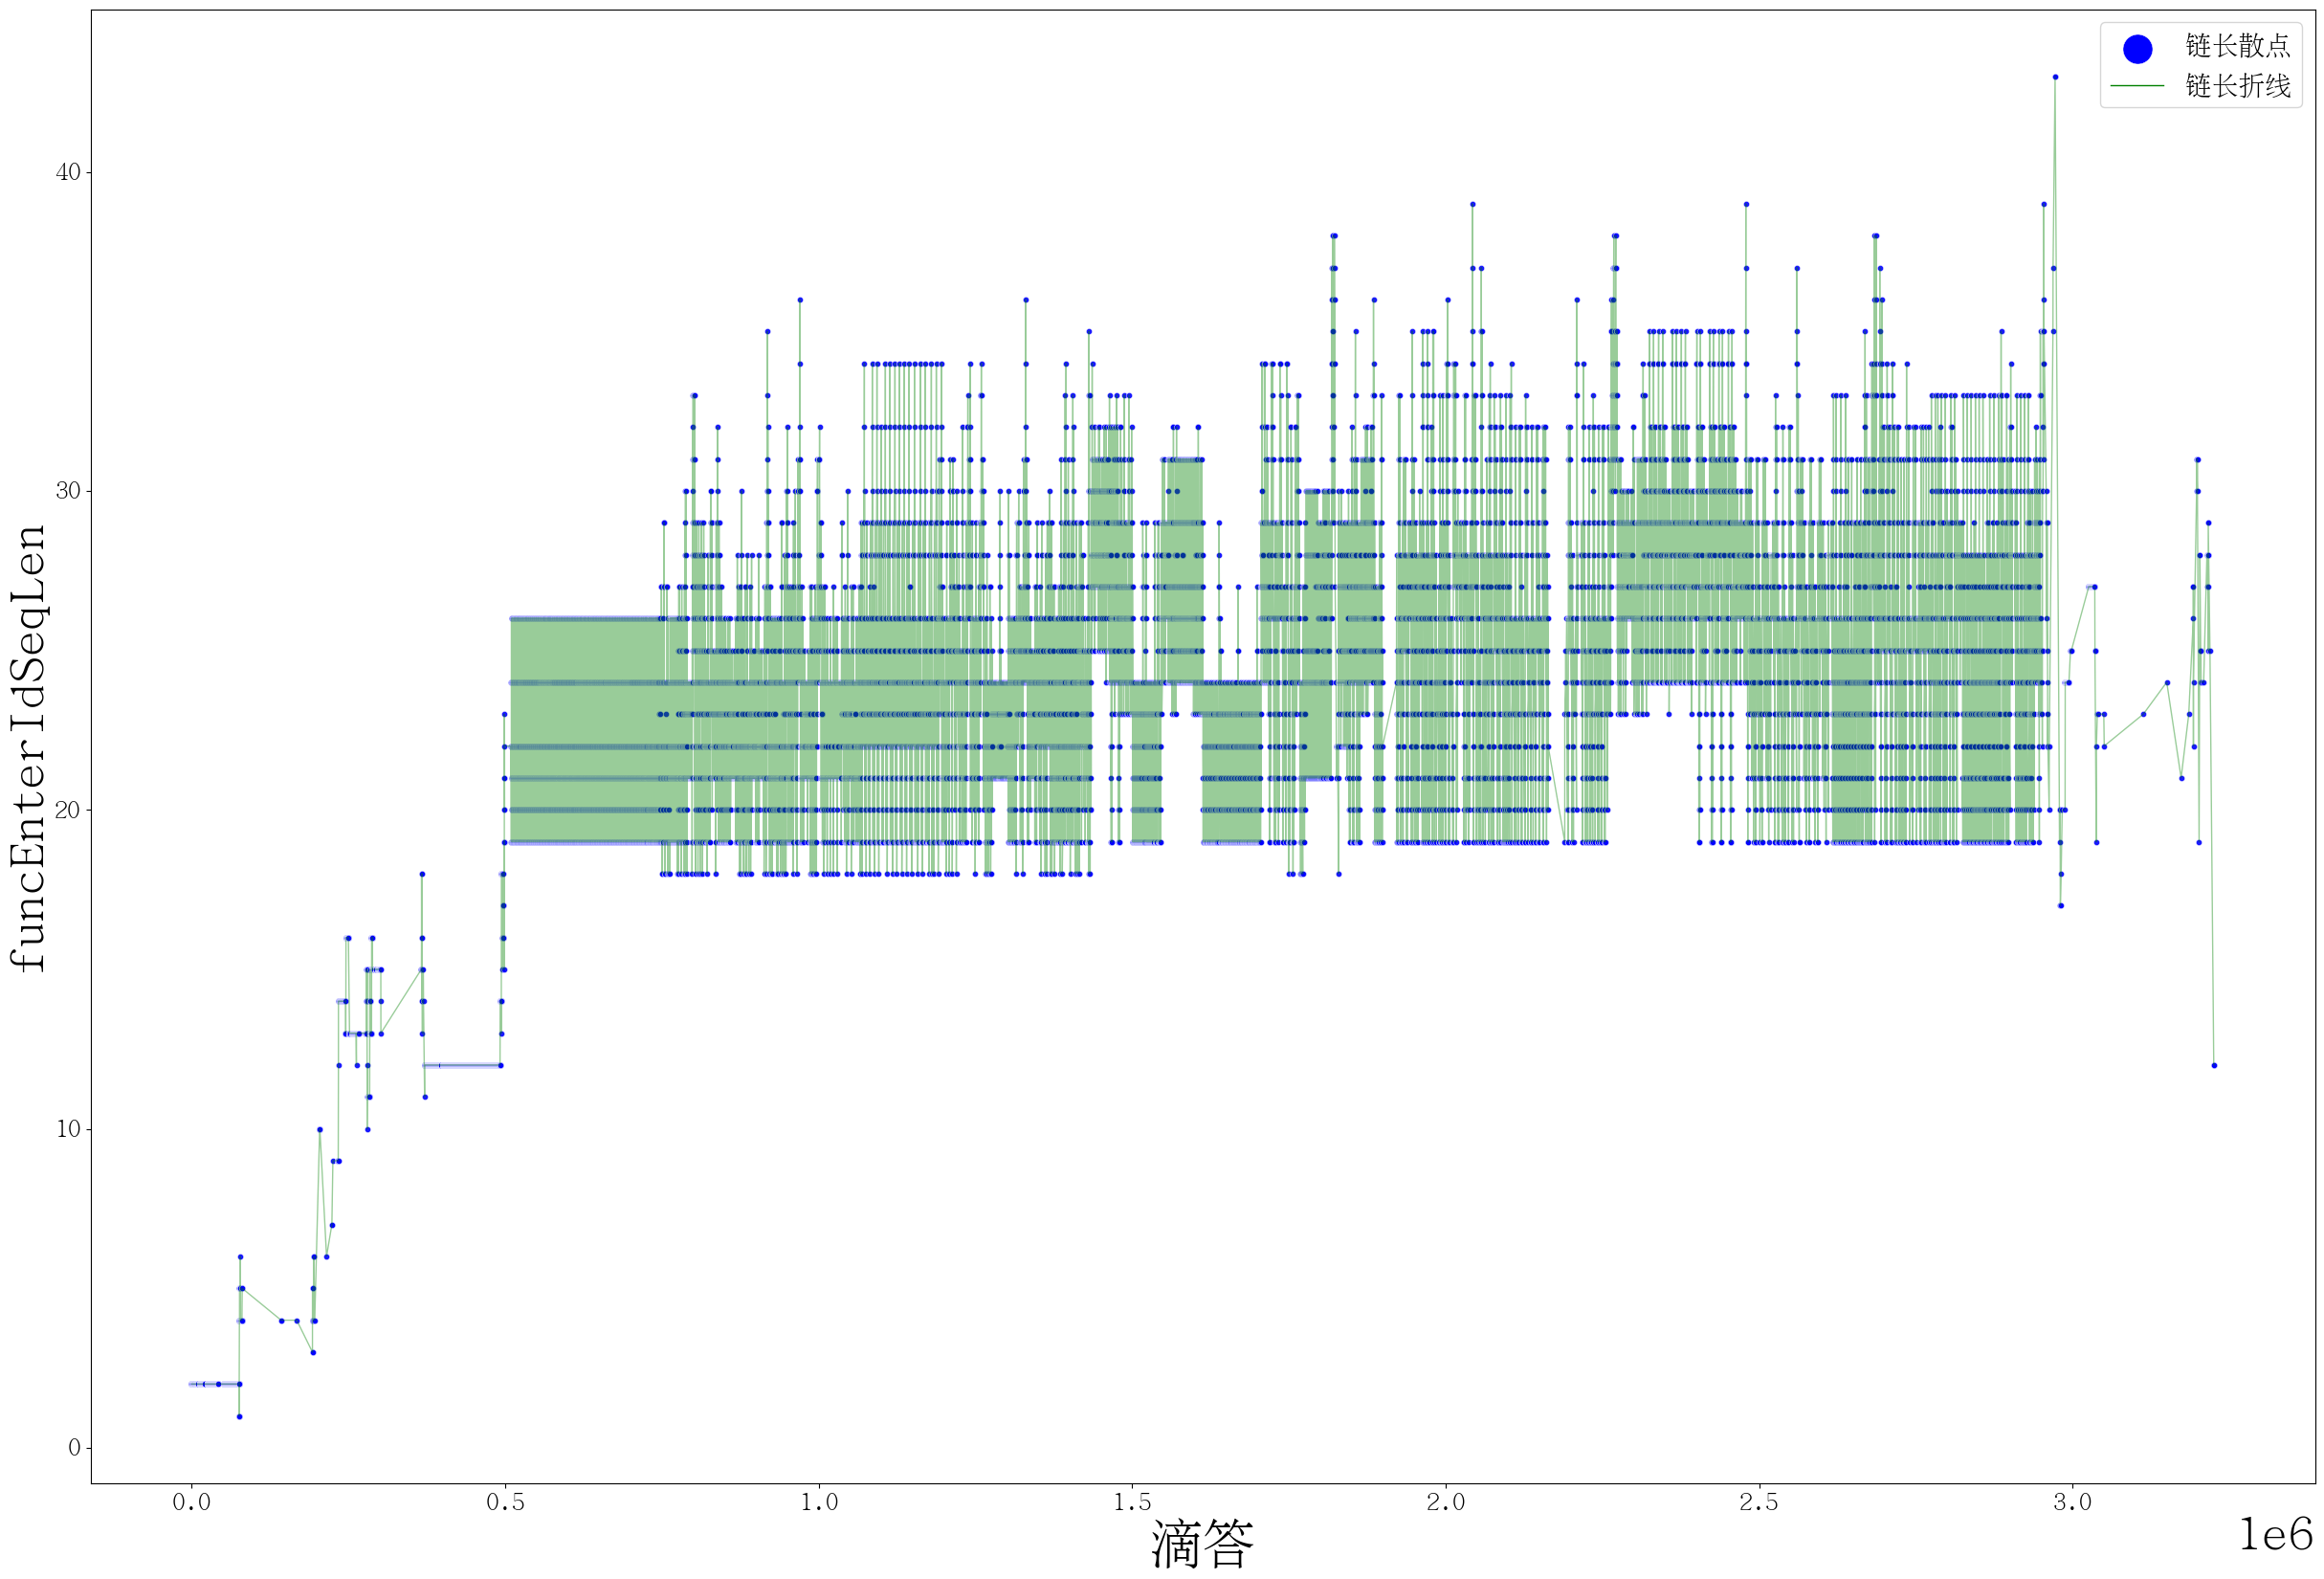

In [52]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.rcParams['font.size'] = 20

g1=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长散点',color='blue',ax=ax)  
g2=seaborn.lineplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.4, linewidth=1, label='链长折线',color='green',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

##  打印长时函数、短时函数列表

In [53]:
时长边界

200

In [54]:
list( df[df.funcId.isin(本地时长funId们)].funcName.unique() )



['llvm::StringMapImpl::RehashTable',
 'llvm::opt::OptTable::OptTable',
 'llvm::opt::OptTable::addValues',
 'llvm::cl::ExpandResponseFiles',
 'llvm::opt::OptTable::ParseArgs',
 'isInput',
 'normalizeSimpleFlag',
 'clang::driver::tools::Clang::ConstructJob',
 'shouldEnableVectorizerAtOLevel',
 '(anonymous namespace)::CommandLineParser::ResetAllOptionOccurrences',
 'clang::CompilerInvocation::ParseCodeGenArgs',
 '(anonymous namespace)::CommandLineParser::ParseCommandLineOptions',
 'InitializePredefinedMacros',
 'clang::SourceManager::createFileID',
 'clang::SourceManager::getOrCreateContentCache',
 'llvm::DataLayout::parseSpecifier',
 'clang::Builtin::Context::initializeBuiltins',
 'clang::ParseAST',
 'clang::Lexer::Lexer',
 'clang::Preprocessor::Lex',
 'clang::Lexer::LexStringLiteral',
 'clang::SourceManager::getPresumedLoc',
 'clang::SrcMgr::LineOffsetMapping::get',
 'clang::Lexer::LexIdentifierContinue',
 'clang::Preprocessor::ReadOptionalMacroParameterListAndBody',
 'clang::Lexer::Ski

In [55]:
list ( df[df.funcId.isin(本地时短funId们)].funcName.unique() )

['llvm::cl::getGeneralCategory',
 'llvm::cl::OptionCategory::registerCategory',
 'llvm::ManagedStaticBase::RegisterManagedStatic',
 'llvm::llvm_is_multithreaded',
 'getManagedStaticMutex',
 'llvm::cl::Option::setArgStr',
 'llvm::cl::Option::addArgument',
 'llvm::StringMapImpl::LookupBucketFor',
 'llvm::StringMapImpl::init',
 'createTable',
 'getHashTable',
 'llvm::allocate_buffer',
 'llvm::RegisterBank::RegisterBank',
 'llvm::cl::AddLiteralOption',
 'llvm::SmallVectorBase::grow_pod',
 'getNewCapacity',
 'llvm::DebugCounter::instance',
 'llvm::BranchProbability::BranchProbability',
 'llvm::MCFragment::MCFragment',
 'llvm::PassRegistry::getPassRegistry',
 'llvm::PassRegistry::registerPass',
 'llvm::Regex::Regex',
 'readRequiredParams',
 'clang::ento::CallDescription::CallDescription',
 '(anonymous namespace)::getExpectedProducerName',
 '(anonymous namespace)::SegmentInjection::SegmentInjection',
 'clang_main',
 'clang::noteBottomOfStack',
 'getStackPointer',
 'llvm::InitLLVM::InitLLVM',
